# 2. Probability Distributions


### *Table of Contents*

* 2.1 [Binary Variables](#2.1-Binary-Variables)
    * 2.1.1 [The Beta Distribution](#2.1.1-The-beta-distribution)
* 2.2 [Multinomial Variables](#2.2-Multinomial-Variables)
    * 2.2.1 [The Dirichlet Distribution](#2.2.1-The-Dirichlet-distribution)
* 2.3 [Gaussian Distribution](#2.3-Gaussian-Distribution)
    * 2.3.4 [Maximum likelihood for the Gaussian](#2.3.4-Maximum-likelihood-for-the-Gaussian)
    * 2.3.5 [Sequential estimation](#2.3.5-Sequential-estimation)
    * 2.3.6 [Bayesian inference for the Gaussian](#2.3.6-Bayesian-inference-for-the-Gaussian)
    * 2.3.7 [Student's t-distribution](#2.3.7-Student's-t-distribution)
    * 2.3.9 [Mixtures of Gaussians](#2.3.9-Mixtures-of-Gaussians)
* 2.5 [Nonparametric Methods](#2.5-Nonparametric-Methods)
    * 2.5.1 [Kernel density estimators](#2.5.1-Kernel-density-estimators)
    * 2.5.2 [Nearest-neighbour methods](#2.5.2-Nearest-neighbour-methods)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.datasets import make_classification
from prml.datasets import load_old_faithful
from prml.distribution import (
    Bernoulli,
    Binomial,
    Beta,
    Categorical,
    Multinomial,
    Dirichlet,
    Gaussian,
    MultivariateGaussian,
    Gamma,
    StudentT
)
from prml.neighbors import (
    NearestNeighborsDensity,
    KNearestNeighborsClassifier
)

# Set random seed to make deterministic
np.random.seed(0)

# Ignore zero divisions and computation involving NaN values.
np.seterr(divide = 'ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

## 2.1 Binary Variables

Consider a single binary random variable $x \in \{0, 1\}$, for instance $x$ might be the outcome of flipping a coin. Then, the probability of heads ($x=1$) can be denoted by a parameter $\mu$ so that,

$$
p(x=1|\mu) = \mu
$$

where $0 \leq \mu \leq 1$. The *Bernoulli* probability distribution over $x$ has therefore the form,

$$
\text{Bern}(x|\mu) = \mu^x(1-\mu)^{1-x}
$$

It is easily verified that the Bernoulli distribution has mean given by,

$$
\mathbb{E}[x] = \sum_{x \in \{0, 1\}} x\text{Bern}(x|\mu) =
\sum_{x \in \{0, 1\}} x\mu^x(1-\mu)^{1-x} =
\mu^1(1-\mu)^0 =
\mu
$$

and variance given by,

$$
\begin{align*}
\text{var}[x] &= \mathbb{E}[x]^2 - \mathbb{E}[x^2] \\
&= \mu^2 - \sum_{x \in \{0, 1\}} x^2\text{Bern}(x|\mu) \\
&= \mu^2 - \sum_{x \in \{0, 1\}} x^2\mu^x(1-\mu)^{1-x} \\
&= \mu^2 - \mu = \mu(\mu - 1)
\end{align*}
$$

Now suppose we have given a data set $\mathcal{D} = \{x_1,\dots,x_N\}$ of observed values sampled from an **unknown** Bernoulli distribution (outcomes of coin tosses), that is, the $\mu$ parameter (probability of heads) is unknown.

Fair coin   --  Heads: 51 Tails: 49
Biased coin --  Heads: 16 Tails: 84


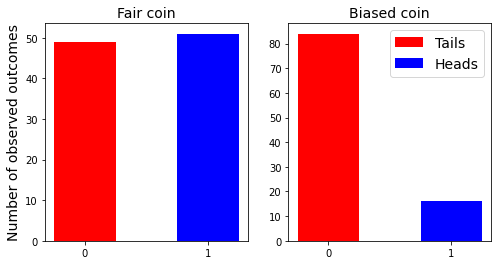

In [2]:
# For demonstration purposes we shall create a data set from a fair coin (mu = 0.5)
# and another data set from a biased coin favoring tails (mu = 0.2).

# Number of coin tosses per data set
N = 100

# Fair coin
mu_fair = 0.5
true_distribution_fair = Bernoulli(mu_fair)
D_fair = true_distribution_fair.draw(N)

print("Fair coin   -- ", "Heads:", sum(D_fair == 1), "Tails:", sum(D_fair == 0))

# Biased coin
mu_biased = 0.2
true_distribution_biased = Bernoulli(mu_biased)
D_biased = true_distribution_biased.draw(N)

print("Biased coin -- ", "Heads:", sum(D_biased == 1), "Tails:", sum(D_biased == 0))

plt.figure(figsize=(8, 4))
plt.subplot(1,2,1)
b = plt.bar([0,1], [sum(D_fair == 0), sum(D_fair == 1)], color=['red','blue'], width=0.5)
b[0].set_label("Tails")
b[1].set_label("Heads")
plt.ylabel("Number of observed outcomes", fontsize=14)
plt.xticks([0, 1])
plt.title("Fair coin", fontsize=14)

plt.subplot(1,2,2)
b = plt.bar([0,1], [sum(D_biased == 0), sum(D_biased == 1)], color=['red','blue'], width=0.5)
b[0].set_label("Tails")
b[1].set_label("Heads")
plt.xticks([0, 1])
plt.title("Biased coin", fontsize=14)
plt.legend(fontsize=14)

plt.show()

We can use the likelihood function on the assumption that the observations are drawn independently from $\text{Bern}(x|\mu)$, so that,

$$
p(\mathcal{D}|\mu) = \prod_{n=1}^N \text{Bern}(x_n|\mu) = \prod_{n=1}^N \mu^{x_n}(1-\mu)^{1-x_n}
$$

Then, following the frequentist approach, we can estimate the value of $\mu$ by maximizing the logarithm of the likelihood given by

$$
\begin{align*}
\ln p(\mathcal{D}|\mu) &= \ln \bigg( \prod_{n=1}^N \mu^{x_n}(1-\mu)^{1-x_n} \bigg) \\
&= \sum_{n=1}^N \ln \big( \mu^{x_n}(1-\mu)^{1-x_n} \big) \\
&= \sum_{n=1}^N \bigg( \ln \big( \mu^{x_n} \big) + \ln \big( (1-\mu)^{1-x_n} \big) \bigg) \\
&= \sum_{n=1}^N \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) 
\end{align*}
$$

Given an observed data set $\mathcal{D}$, we can plot the value of the log-likelihood against the values of $\mu \in [0,1]$.

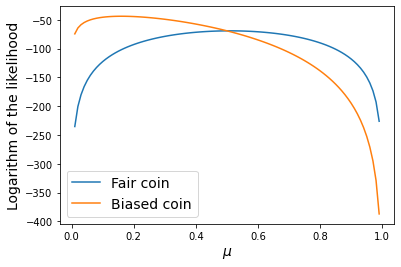

In [3]:
mu_space = np.arange(0.01, 1, 0.01)
ll = np.zeros(mu_space.shape)

for i, mu_i  in enumerate(mu_space):
    ll[i] = Bernoulli(mu_i).log_likelihood_iid(D_fair)

plt.plot(mu_space, ll, label="Fair coin")

for i, mu_i  in enumerate(mu_space):
    ll[i] = Bernoulli(mu_i).log_likelihood_iid(D_biased)

plt.plot(mu_space, ll, label="Biased coin")

plt.xlabel("$\mu$", fontsize=14); plt.ylabel("Logarithm of the likelihood", fontsize=14)
plt.legend(fontsize=14); plt.show()

Note that the **maximum** of the likelihood is achieved around $\mu=0.5$ for the fair coin and $\mu=0.2$ for the biased coin. Therefore, using calculus, if we set the derivative of $\ln p(\mathcal{D}|\mu)$ with respect to $\mu$ equal to zero, we obtain

$$
\begin{align*}
&\frac{\partial}{\partial\mu} \ln p(\mathcal{D}|\mu) = 0 \Leftrightarrow \\
&\frac{\partial}{\partial\mu} \sum_{n=1}^N \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \frac{\partial}{\partial\mu} \bigg( x_n\ln\mu + (1-x_n)\ln(1-\mu) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n - \frac{1}{1 - \mu}(1-x_n) \bigg) = 0 \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n - \frac{1}{1 - \mu} + \frac{1}{1 - \mu}x_n \bigg) = 0\Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1}{\mu}x_n + \frac{1}{1 - \mu}x_n \bigg) = \frac{N}{1 - \mu} \Leftrightarrow \\
&\sum_{n=1}^N  \bigg( \frac{1 - \mu}{\mu}x_n + x_n \bigg) = N \Leftrightarrow \\
&\sum_{n=1}^N \frac{1}{\mu}x_n = N \Leftrightarrow \\
&\mu_{ML} = \frac{1}{N}\sum_{n=1}^N x_n
\end{align*}
$$

which is known as the *sample mean*. Thus, the probability of landing heads ($\mu$), according to the maximum likelihood estimator, is given by the fraction of observations of heads in the data set $\mathcal{D}$. Indeed caclulating the sample mean gives us a very accurate estimation of the true values for $\mu$.

In [4]:
print("Maximum likelihood 𝜇 for the fair coin is", sum(D_fair == 1) / N)
print("Maximum likelihood 𝜇 for the biased coin is", sum(D_biased == 1) / N)

Maximum likelihood 𝜇 for the fair coin is 0.51
Maximum likelihood 𝜇 for the biased coin is 0.16


However, A problem that arises from this result is that for small data sets the estimation can be unreasonable. For instance, in the following plot, note that for small data sets $N < 100$, the estimated $\mu_{\text{ML}}$ can deviate significantly from the true $\mu$ leading to incorrect probabilities for the future observations.

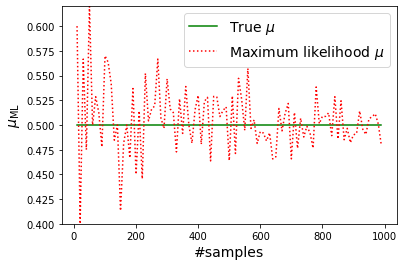

In [5]:
ml_model = Bernoulli()
samples = list(range(10, 1000, 10))
mu_estimations = []

for N in samples:
    D = true_distribution_fair.draw(N)
    ml_model.ml(D)
    mu_estimations.append(ml_model.mu)
    
plt.plot(samples, [mu_fair for N in samples], color="g", label="True $\mu$")
plt.plot(samples, mu_estimations, color="r", linestyle=":", label="Maximum likelihood $\mu$")
plt.xlabel("#samples", fontsize=14); plt.ylabel("$\mu_{\mathrm{ML}}$", fontsize=14)
plt.ylim([min(mu_estimations), max(mu_estimations)])
plt.legend(fontsize=14); plt.show()

Now, if we toss a coin $5$ times, then, the probability of getting $3$ heads and then $2$ tails is

$$
p(x_1=1)p(x_2=1)p(x_3=1)p(x_4=0)p(x_5=0) = \mu \times \mu \times \mu \times (1 - \mu) \times (1 - \mu)
$$

or more general for $N$ times and $m$ heads, 

$$
\mu^m(1-\mu)^{N-m}
$$

However, this is just one way to get $m$ heads, there are many other sequences of $N$ trials that would give us $m$ heads. How many exactly?

The distribution describing the number of $m$ observations of $x=1$ in a sample dataset of size $N$ is called the [*Binomial* distribution](https://www.youtube.com/watch?v=8idr1WZ1A7Q), and is given by

$$
\text{Bin}(m|N,\mu) = 
\left(\!
    \begin{array}{c}
      N \\
      m
    \end{array}
\!\right)
\mu^m(1 - \mu)^{N-m}
$$

where

$$
\left(\!
    \begin{array}{c}
      N \\
      m
    \end{array}
\!\right)
= \frac{N!}{(N-m)!m!}
$$

is the numbers of ways of choosing $m$ objects out of a total of $N$ identical objects, and is called the [binomial coefficient](https://en.wikipedia.org/wiki/Binomial_coefficient).

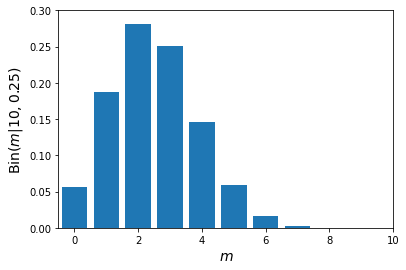

In [6]:
model = Binomial(10, 0.25)
y = model.pdf(np.arange(0, 10))

plt.bar(np.arange(0, 10), y)
plt.xlim([-0.5, 10]); plt.ylim([0, 0.3])
plt.xlabel("$m$", fontsize=14); plt.ylabel("$\mathrm{Bin}(m|10,0.25)$", fontsize=14)
plt.show()

### 2.1.1 The beta distribution

We have seen that the maximum likelihood estimator for the parameter $\mu$ in the Bernoulli and binomial distributions, is given by the fraction of the observations in the data having $x=1$, which can lead to over-fitted results for small data sets. In order to arrive to more sensible results, we develop a **Bayesian treatment** for the problem by introducing a prior distribution $p(\mu)$ over the parameter $\mu$.

Note that the likelihood function takes the form of the product of factors of the form $\mu^x(1-\mu)^{(1-x)}$. We would like to choose a prior proportional to powers of $\mu$ and $(1-\mu)$ in order for the posterior to have the same functional form as the prior, since the posterior is proportional to the product of the prior and the likelihood. This important property is called **conjugacy**.

We therefore we choose a prior, called the **beta** distribution, given by

$$
\text{Beta}(\mu|a,b) = \frac{\Gamma(a + b)}{\Gamma(a)\Gamma(b)} \mu^{a-1}(1-\mu)^{b-1}
$$

where $a$ and $b$ are often called hyperparameters because they control the distribution of the parameter $\mu$. In order to give an intuition about the hyperparameteres, we plot the beta distribution for various values of $a$ and $b$.

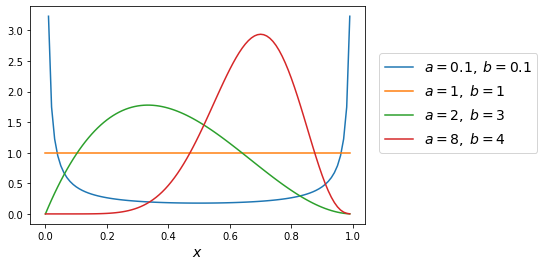

In [7]:
x_space = np.arange(0, 1, 0.01)

for a, b in [(0.1, 0.1), (1, 1), (2, 3), (8, 4)]:
    model = Beta(a, b)
    plt.plot(x_space, model.pdf(x_space), label="$a={},\; b={}$".format(a, b))

plt.xlabel("$x$", fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.85), loc=2, borderaxespad=1, fontsize=14); plt.show()

The fraction of $\Gamma(x)$ functions ensures that the beta distribution is normalized, so that

$$
\int_0^1 \text{Beta}(\mu|a,b)d\mu = 1
$$

The mean is given by

$$
\begin{align*}
\mathbb{E}[\mu] &= \int_0^1 \mu\text{Beta}(\mu|a,b)d\mu \\
&= \int_0^1 \mu\frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \mu^{a-1}(1-\mu)^{b-1} d\mu \\
&= \int_0^1 \frac{\Gamma(a+b)}{\Gamma(a)\Gamma(b)} \mu^a(1-\mu)^{b-1} d\mu \\
&= \int_0^1 \frac{a\Gamma(a+b+1)}{(a+b)\Gamma(a+1)\Gamma(b)} \mu^a(1-\mu)^{b-1} d\mu \\
&= \frac{a}{a+b}\int_0^1 \frac{\Gamma(a+b+1)}{\Gamma(a+1)\Gamma(b)} \mu^a(1-\mu)^{b-1} d\mu \\
&= \frac{a}{a+b}\int_0^1 \text{Beta}(\mu|a+1,b)d\mu \\
&= \frac{a}{a+b}
\end{align*}
$$

where we have taken advantage of the property $\Gamma(x+1)=x\Gamma(x)$. The variance is given by

$$
\text{var}[\mu] = \frac{ab}{(a+b)^2(a+b+1)}
$$

The posterior distribution over $\mu$ can be obtained by multiplying the beta prior by the binomial likelihood function and **normalizing**,

$$
p(\mu|m,l,a,b) = \frac{\Gamma(m+a+l+b)}{\Gamma(m+a)\Gamma(l+b)} \mu^{m+a-1}(1-\mu)^{l+b-1}
$$

where $l=N-m$, and corresponds to the number of times $x=0$.

Note that the effect of observing a data set of $m$ observations of $x=1$ and $l$ observations of $x=0$ is to  increase the value of $a$ by $m$, and the value of $b$ by $l$, from the prior to the posterior distribution. Thus, the hyperparameters $a$ and $b$ in the prior represent the number of observations of $x=1$ and $x=0$, respectively. Furthermore, the posterior distribution can act as the prior if subsequent observations arrive. Imagine taking one observation at a time and after each observation updating the current posterior distribution by multiplying by the likelihood of the incoming observation. At each stage, the posterior is a beta distribution incorporating some number of (prior and actual) observed values for $x=1$ and $x=0$ given by the parameters $a$ and $b$. Incorporation an additional observation of $x=1$ corresponds to incrementing the value of $a$ by $1$, whereas for $x=0$ increment $b$ by $1$.

We present a sequence of such Bayesian inference steps, where three observations of $x=1$ arrive before a single observation of $x=0$. Note how the prior revises the form of the **unnormalized** posterior on each update step according to the likelihood. Apart from the first step, where the prior is a Beta distribution having paramater $a=2$ and $b=2$, in each subsequent step the prior is the **unnormalized** posterior of the previous step.

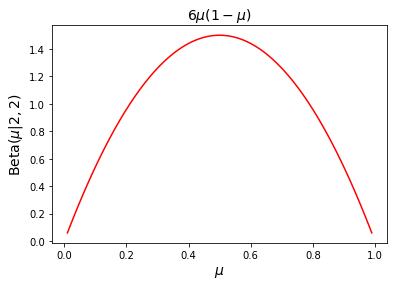

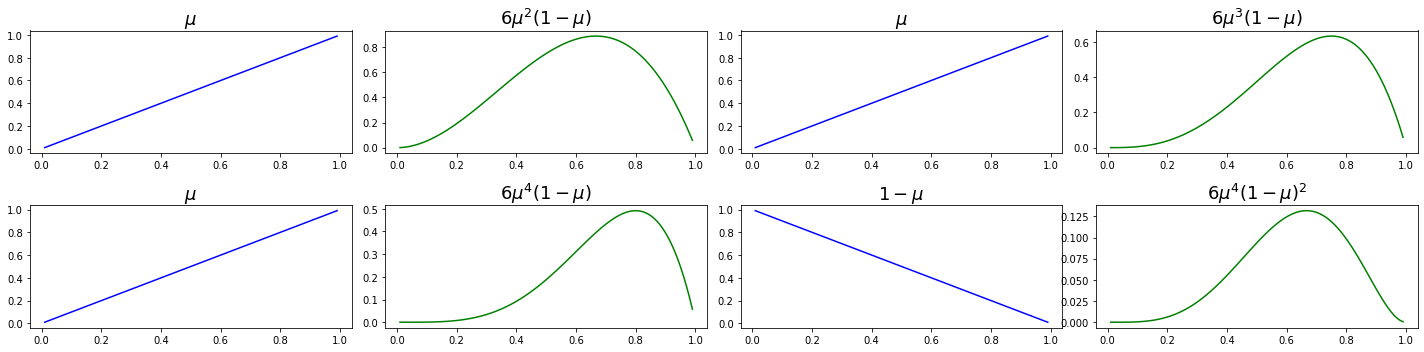

In [8]:
# The Beta conjugate prior for the Binomial distribution (starting parameter a=2, b=2)
prior = Beta(a=2, b=2)
plt.plot(mu_space, prior.pdf(mu_space), color='red')
plt.xlabel('$\mu$', fontsize=14); plt.ylabel('$\mathrm{Beta}(\mu|2,2)$', fontsize=14)
plt.title(prior.change_notation({'x': 'mu'}).to_latex, fontsize=14)
plt.show()

# Apply a sequence of Bayesian inference steps, as more observations arrive in the form of a likelihood
plt.figure(figsize=(20, 5))

# Row 1
plt.subplot(2,4,1)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(1)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,2)
plt.tight_layout()
posterior = prior.change_notation({'x': 'mu'}) * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

plt.subplot(2,4,3)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(1)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,4)
plt.tight_layout()
posterior = posterior * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

# Row 2
plt.subplot(2,4,5)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(1)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,6)
plt.tight_layout()
posterior = posterior * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

plt.subplot(2,4,7)
plt.tight_layout()
likelihood = Binomial(n=1).pdf(0)
plt.plot(mu_space, likelihood.pdf(mu=mu_space), color='blue')
plt.title(likelihood.to_latex, fontsize=18)

plt.subplot(2,4,8)
plt.tight_layout()
posterior = posterior * likelihood
plt.plot(mu_space, posterior.pdf(mu=mu_space), 'g')
plt.title(posterior.to_latex, fontsize=18)

plt.show()

Thus, the **sequential** approach to learning arises naturally when we adopt a Bayesian viewpoint. It is **independent** of the choice of prior and of the likelihood function and **depends only** on the assumption of i.i.d. data. Sequential methods make use of observations one at a time, or in small batches, and then discard them before the next observations are used. They can be used, for example, in real-time learning scenarios where a steady stream of data is arriving, and predictions must be made before all of the data is seen. Maximum likelihood methods can also be cast into a sequential framework.

If our goal is to predict the outcome fo the next trial, then we must evaluate the predictive distribution of $x$ given the observed data $\mathcal{D}$ given by,

$$
p(x=1|\mathcal{D}) = \frac{m + a}{m + a + l + b}
$$

which essentially represents the fraction of observations (actual and prior) that corresponds to $x=1$. Note that in the limit of an infinitely large data set $m,l \to \infty$, $p(x=1|\mathcal{D})$ reduces to the maximum likelihood estimator $\frac{m}{N}$. 

It is a very **general property** that the Bayesian and maximum likelihood results are identical in the limit of infinitely large data sets. For finite data set, the posterior mean for $\mu$ always lies between the prior mean and the maximum likelihood estimate for $\mu$, corresponding to the sample mean.

## 2.2 Multinomial Variables

A binary variable is good for representing a coin toss, but generally we would like to have more states, such as the number rolled on a die. Such discrete random variables can take on one of $K$ possible mutually exclusive states of the form

$$
\mathbf{x} = (0,0,1,0,0,0)^{\text{T}}
$$

where each state $k$ is represented by the $k^{th}$ element being $1$ and all other elements being $0$. If we denote the probability of $x_k=1$ by the parameter $\mu_k$, then the distribution over $\mathbf{x}$ can be regarded as a generalization of the Bernoulli distribution, called the *categorical distribution*, and is given by

$$
p(\mathbf{x}|\boldsymbol\mu) = \prod_{k=1}^K \mu_k^{x_k}
$$

where the parameters $\mathbf{x} = (\mu_1,\dots\mu_K)^{\text{T}}$ must satisfy $\mu_k \geq 0$ and $\sum_k \mu_k = 1$ because they represent probabilities. Note that $\mu_k^{x_k}$ becomes $1$ for every element except the $x_k=1$, and so the product picks the probability $\mu_k$ for the state represented by $\mathbf{x}$.


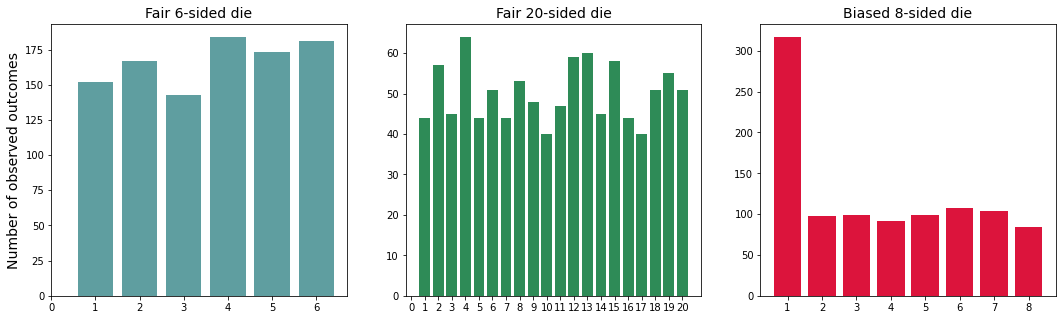

In [9]:
plt.figure(figsize=(18, 5))

# Lets roll 1000 fair 6-sided dice
plt.subplot(1,3,1)
fair_rolls_6 = Categorical(mu=np.ones(6) / 6).draw(1000)
plt.bar(np.arange(1,7), sum(fair_rolls_6), color="cadetblue")
plt.ylabel("Number of observed outcomes", fontsize=14)
plt.xticks(np.arange(6+1))
plt.title("Fair 6-sided die", fontsize=14)

# then 1000 fair 20-sided dice
plt.subplot(1,3,2)
fair_rolls_20 = Categorical(mu=np.ones(20) / 20).draw(1000)
plt.bar(np.arange(1,21), sum(fair_rolls_20), color="seagreen")
plt.xticks(np.arange(20+1))
plt.title("Fair 20-sided die", fontsize=14)

# finally 1000 biased 8-sided dice
plt.subplot(1,3,3)
biased_rolls_8 = Categorical(mu=np.array([3, 1, 1, 1, 1, 1, 1, 1], float) / 10).draw(1000)
plt.bar(np.arange(1,9), sum(biased_rolls_8), color="crimson")
plt.title("Biased 8-sided die", fontsize=14)

plt.show()

It is easily seen that the distribution is normalized

$$
\begin{align*}
\sum_{\mathbf{x}} p(\mathbf{x}|\boldsymbol\mu) &= \sum_{\mathbf{x}}\prod_{k=1}^K \mu_k^{x_k} \\
&= \prod_{k=1}^K \mu_k^{x_k^1} + \dots + \prod_{k=1}^K \mu_k^{x_k^K} \\
&= \sum_{k=1}^K \mu_k = 1
\end{align*}
$$

and that

$$
\begin{align*}
\mathbb{E}[\mathbf{x}] &= \mathbb{E}[\mathbf{x}|\boldsymbol\mu] \\
&= \sum_\mathbf{x} \mathbf{x} p(\mathbf{x}|\boldsymbol\mu) \\
&= \sum_\mathbf{x} \mathbf{x} \prod_{k=1}^K \mu_k^{x_k} \\
&= \mathbf{x}^1 \prod_{k=1}^K \mu_k^{x_k^1} + \dots + \mathbf{x}^K \prod_{k=1}^K \mu_k^{x_k^K} \\
&= (\mu_1,\dots,\mu_K)^\text{T}
\end{align*}
$$

Consider a data set $\mathcal{D}$ of $N$ independent observations $\mathbf{x}_1,\dots,\mathbf{x}_N$, the corresponding likelihood function is given by

$$
\begin{align*}
p(\mathcal{D}|\boldsymbol\mu) &= \prod_{n=1}^N \prod_{k=1}^K \mu_k^{x_{nk}} \\
&= \prod_{k=1}^K \mu_k^{\Large(\sum_{n=1}^N x_{nk}\Large)} \\
&= \prod_{k=1}^K \mu_k^{m_k}
\end{align*}
$$

Therefore, given some observed dice rolls, we can plot, for instance, how likely it is that the number one in the die that produced these observations is biased in a certain way

[0.28571429 0.14285714 0.14285714 0.14285714 0.14285714 0.14285714]
[0.5 0.1 0.1 0.1 0.1 0.1]


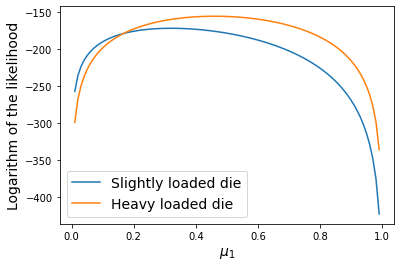

In [10]:
N = 100

def likelihood(mu_1, data):
    mus = (np.ones(6) * (1 - mu_1)) / 5
    mus[0] = mu_1
    return Categorical(mu=mus).log_likelihood_iid(data)

mu_space = np.linspace(0, 1, 100)

nums = np.array([2,1,1,1,1,1], float)
print(nums / sum(nums))
slightly_loaded_data = Categorical(mu=nums / sum(nums)).draw(N)
plt.plot(mu_space, [likelihood(mu_1, slightly_loaded_data) for mu_1 in mu_space], label="Slightly loaded die")

nums = np.array([5,1,1,1,1,1], float)
print(nums / sum(nums))
heavy_loaded_data = Categorical(mu=nums / sum(nums)).draw(N)
plt.plot(mu_space, [likelihood(mu_1, heavy_loaded_data) for mu_1 in mu_space], label="Heavy loaded die")

plt.xlabel("$\mu_1$", fontsize=14); plt.ylabel("Logarithm of the likelihood", fontsize=14)
plt.legend(fontsize=14); plt.show()

In order to maximize $\ln p(\mathcal{D}|\boldsymbol\mu)$, taking account of the constraint $c(\boldsymbol\mu)=\sum_k \mu_k - 1$, we use a Lagrange multiplier $\lambda$ and maximizing

$$
L(\boldsymbol\mu,\lambda) = \ln p(\mathcal{D}|\boldsymbol\mu) + \lambda c(\boldsymbol\mu)
$$

By setting the gradient to zero, we obtain the maximum likelihood solution in the form

$$
\mu_k = \frac{m_k}{N}
$$

which is the fraction of the $N$ observations for which $x_k=1$. Thus, the maximum likelihood solution, similar to the Bernoulli distribution, is the *sample mean* on each dimension.

In [11]:
print("Maximum likelihood of 𝝁 for the slightly loaded die is", np.mean(slightly_loaded_data, axis=0))
print("Maximum likelihood of 𝝁 for the heavy loaded die is", np.mean(heavy_loaded_data, axis=0))

Maximum likelihood of 𝝁 for the slightly loaded die is [0.32 0.13 0.14 0.12 0.13 0.16]
Maximum likelihood of 𝝁 for the heavy loaded die is [0.46 0.11 0.11 0.12 0.09 0.11]


The joint distribution of the quantities $m_1,\dots,m_K$, conditioned on the parameters $\boldsymbol\mu$ and the total number $N$ of observations, is known as the *multinomial* distribution. It would give us the number of $1, 2, 3, \dots$ rolled in a sample dataset of size $N$, the same way the binomial distribution gave us the number of heads. The multinomial distribution is given by
 
$$
\text{Mult}(m_1,\dots,m_K|\boldsymbol\mu,N) = 
\left(\!
    \begin{array}{c}
      N \\
      m_1m_2\dots m_K
    \end{array}
\!\right)
\prod_{k=1}^K \mu_k^{m_k}
$$

where

$$
\left(\!
    \begin{array}{c}
      N \\
      m_1m_2\dots m_K
    \end{array}
\!\right) =
\frac{N!}{m_1!m_2!\dots m_K!}
$$

 is the number of ways to partition $N$ objects into $K$ groups of size $m_1,\dots,m_K$, and is called the [multinomial coefficient](https://en.wikipedia.org/wiki/Multinomial_theorem).
 
We cannot really plot the multinomial distribution directly, because of the many dimensions of $\mathbf{m}$. However, we can show the distribution of the number of ones rolled (constraining the other numbers), using various weighted dice.

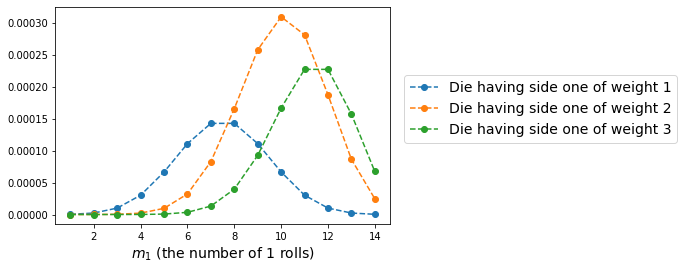

In [12]:
# Consider N tosses of a 6-sided die. 
N = 35
m_space = np.arange(1, 15)

# The weight parameter determines how biased is side 1 of the die
for w in [1, 2, 3]:
    nums = np.array([w, 1, 1, 1, 1, 1])
    distribution = Multinomial(N, mu=nums / sum(nums))
    plt.plot(m_space, [distribution.pdf(np.array([m1, 5, 5, 5, 5, 15 - m1]).T) for m1 in m_space], 
             'o--', label='Die having side one of weight %s' % w)

plt.xlabel("$m_1$ (the number of $1$ rolls)" , fontsize=14)
plt.legend(bbox_to_anchor=(1, 0.75), loc=2, borderaxespad=1, fontsize=14); plt.show()

And we can plot the distribution over a $3$ sided die in using a colormap. Note that the plot only depicts two  variables on the axes, since the third can be inferred as they sum to N.

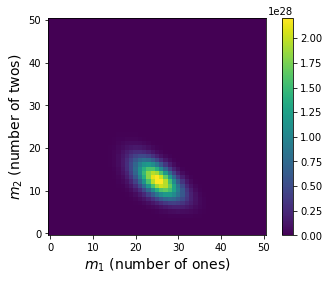

In [13]:
N = 50
m_space = np.arange(N + 1)
distribution = Multinomial(N, mu=np.array([2, 1, 1]).T)

o = np.ones((N + 1, N + 1))
for m1 in m_space:
    for m2 in np.arange((N - m1) + 1):
        m3 = N - m1 - m2
        o[m2, m1] = distribution.pdf(np.array([m1, m2, m3]).T)

plt.imshow(o, origin="lower")
plt.xlabel("$m_1$ (number of ones)", fontsize=14); plt.ylabel("$m_2$ (number of twos)", fontsize=14)
plt.colorbar(); plt.show()

### 2.2.1 The Dirichlet distribution

Similar to the Beta distribution, consider a family of prior distributions for the parameters $\boldsymbol\mu$ of the multinomial distribution, called the *Dirichlet* distribution

$$
\text{Dir}(\boldsymbol\mu|\boldsymbol\alpha) = 
\frac{\Gamma(\alpha_0)}{\Gamma(\alpha_1)\cdots\Gamma(\alpha_K)} \prod_{k=1}^K \mu_k^{\alpha_k-1}
$$

In order to give an intuition we plot the Dirichlet distribution over three variables. Two of them are shown in horizontal axes are coordinates in the plane of the simplex, while the vertical axis corresponds to the value of the density.

<ipython-input-14-888e1d18c0d4>:13: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X1, X2, Z)


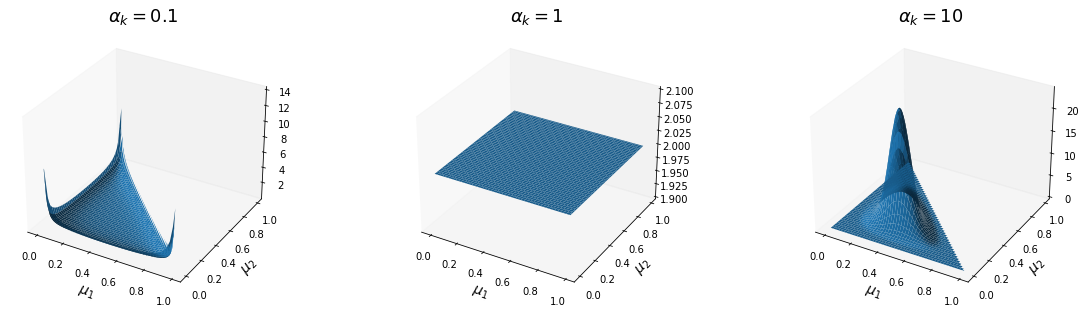

In [14]:
fig = plt.figure(figsize=(20, 5))

for i, alpha in enumerate([0.1, 1, 10]):
    
    distribution = Dirichlet(np.array([alpha, alpha, alpha]))
    X1, X2 = np.meshgrid(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01))
    X3 = 1 - (X1 + X2)

    X = np.array([np.ravel(X1), np.ravel(X2), [float('nan') if x < 0 else x for x in np.ravel(X3)]]).T    
    Z = distribution.pdf(X).reshape(X1.shape)

    ax = fig.add_subplot(1, 3, i + 1, projection='3d'); ax.grid(b=None)
    ax.plot_surface(X1, X2, Z)
    ax.set_xlabel("$\mu_1$", fontsize=14); ax.set_ylabel("$\mu_2$", fontsize=14)
    ax.set_title("$\\alpha_k={}$".format(str(alpha)), fontsize=18)

plt.show()

Multiplying the Dirichlet prior by the multinomial likelihood function and **normalizing**, we obtain the posterior distribution for the parameters $\boldsymbol\mu$ in the form

$$
p(\boldsymbol\mu|\mathcal{D},\boldsymbol\alpha) = 
\text{Dir}(\boldsymbol\mu|\boldsymbol\alpha + \mathbf{m}) =
\frac{\Gamma(\alpha_0 + N)}{\Gamma(\alpha_1 + m_1)\cdots\Gamma(\alpha_K + m_K)} \prod_{k=1}^K \mu_k^{\alpha_k+m_k-1}
$$

Note that the posterior distribution again takes the form of a Dirichlet distribution, confirming that the Dirichlet is indeed a **conjugate prior** for the multinomial distribution. As in the case of the binomial distribution and the beta prior, the parameters $\alpha_k$ of the Dirichlet prior can be interpreted as an *effective number of observations* of $x_k = 1$. Thus, the effect of observing a data set of $\mathbf{m}$ observations for the $K$ states of $\mathbf{x}$ is to increase the values of $\boldsymbol\alpha$ by $\mathbf{m}$ from the prior to the posterior distribution. 

To that end, we present a Bayesian inference step, where an observations of $\mathbf{x}=(1, 0, 0)^\text{T}$ arrives. Given a Dirichlet prior having parameters $\boldsymbol\alpha=(2, 2, 2)^\text{T}$, note how the prior revises the form of the **unnormalized** posterior according to the likelihood.

<ipython-input-15-d6ffc40e19ff>:8: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X1, X2, Z)
<ipython-input-15-d6ffc40e19ff>:26: UserWarning: Z contains NaN values. This may result in rendering artifacts.
  ax.plot_surface(X1, X2, Z)


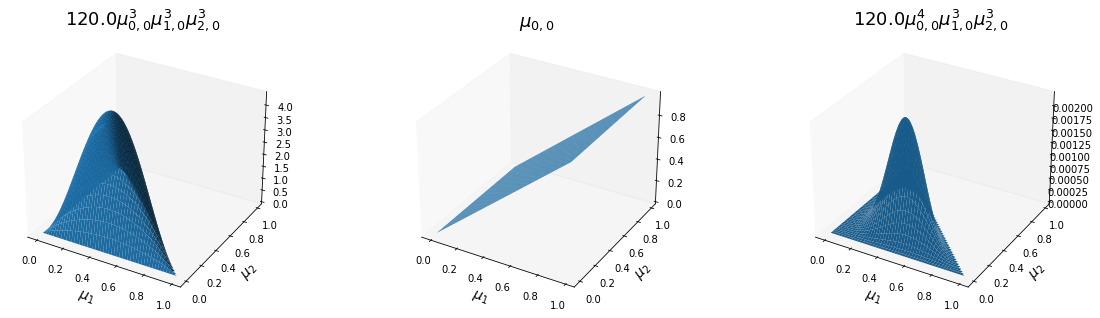

In [15]:
# Apply a sequence of Bayesian inference steps, as more observations arrive in the form of a likelihood
fig = plt.figure(figsize=(20, 5))

# The Dirichlet conjugate prior for the multinomial distribution (starting parameters a=[2, 2, 2])
prior = Dirichlet(alpha=np.array([2, 2, 2]).T)
Z = prior.pdf(X).reshape(X1.shape)
ax = fig.add_subplot(1, 3, 1, projection='3d'); ax.grid(b=None)
ax.plot_surface(X1, X2, Z)
ax.set_xlabel("$\mu_1$", fontsize=14)
ax.set_ylabel("$\mu_2$", fontsize=14)
ax.set_title(prior.change_notation({'x': 'mu'}).to_latex, fontsize=18)

# The multinomial likelihood
ax = fig.add_subplot(1, 3, 2, projection='3d'); ax.grid(b=None)
likelihood = Multinomial(n=1, dim=3).pdf(np.array([1, 0, 0]).T)
Z = likelihood.pdf(mu=X).reshape(X1.shape)
ax.plot_surface(X1, X2, Z)
ax.set_xlabel("$\mu_1$", fontsize=14)
ax.set_ylabel("$\mu_2$", fontsize=14)
ax.set_title(likelihood.to_latex, fontsize=18)

# The resulting posterior
ax = fig.add_subplot(1, 3, 3, projection='3d'); ax.grid(b=None)
posterior = prior.change_notation({'x': 'mu'}) * likelihood
Z = posterior.pdf(mu=X).reshape(X1.shape)
ax.plot_surface(X1, X2, Z)
ax.set_xlabel("$\mu_1$", fontsize=14)
ax.set_ylabel("$\mu_2$", fontsize=14)
ax.set_title(posterior.to_latex, fontsize=18)

plt.show()

## 2.3 Gaussian Distribution

The *Gaussian*, also known as the normal distribution, is a model for the distribution of continuous random variables. In the case of single variable $x$, the Gaussian distribution is given by

$$
\mathcal{N}(x|\mu,\sigma^2) =
\frac{1}{(2\pi\sigma^2)^{1/2}}\exp\Big\{-\frac{1}{2\sigma^2}(x-\mu)^2\Big\}
$$

For a $D$-dimensional vector $\mathbf{x}$, the multivariate Gaussian distribution takes the form

$$
\mathcal{N}(\mathbf{x}|\boldsymbol\mu,\mathbf{\Sigma}) =
\frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}}
\exp\Big\{-\frac{1}{2}(\mathbf{x}-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}-\boldsymbol\mu)\Big\}
$$

where $\boldsymbol\mu$ is a $D$-dimensional mean vector, $\mathbf{\Sigma}$ is a $D\times D$ covariance matrix, while $|\mathbf{\Sigma}|$ denotes the determinant of $\mathbf{\Sigma}$.

The Gaussian distribution can be motivated from a variety of perspectives. For instance, we have seen that for continuous variables, the distribution **maximizing the entropy** is a Gaussian distribution. Moreover, the *central limit theorem* tell us that the sum of a set of random variables, which is of course itself a random variable, has a distribution that becomes increasingly Gaussian as the number of terms increases.

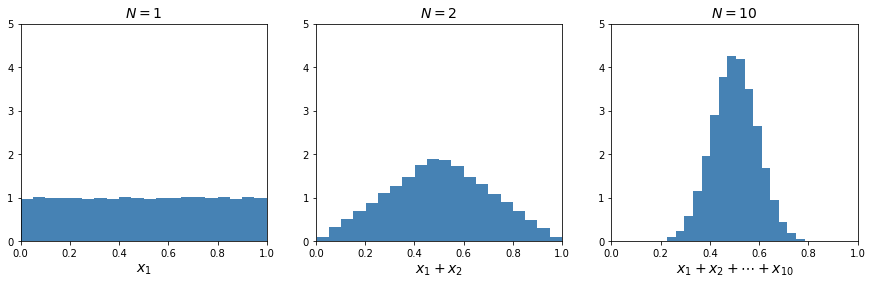

In [16]:
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sample = np.mean(np.random.uniform(0, 1, size=(1, 100000)), axis=0)
plt.hist(sample, bins=20, density=True, color="steelblue")
plt.xlabel("$x_1$", fontsize=14); plt.xlim(0, 1); plt.ylim(0, 5)
plt.title("$N=1$", fontsize=14)

plt.subplot(1, 3, 2)
sample = np.mean(np.random.uniform(0, 1, size=(2, 100000)), axis=0)
plt.hist(sample, bins=20, density=True, color="steelblue")
plt.xlabel("$x_1+x_2$", fontsize=14); plt.xlim(0, 1); plt.ylim(0, 5)
plt.title("$N=2$", fontsize=14)

plt.subplot(1, 3, 3)
sample = np.mean(np.random.uniform(0, 1, size=(10, 100000)), axis=0)
plt.hist(sample, bins=20, density=True, color="steelblue")
plt.xlabel("$x_1+x_2+\cdots+x_{10}$", fontsize=14); plt.xlim(0, 1); plt.ylim(0, 5)
plt.title("$N=10$", fontsize=14)

plt.show()


Although the Gaussian distribution is widely used as a density model, it suffers from significant limitations: 

1. Consider the number of free parameters in the distribution. A general symmetric covariance matrix $\mathbf{\Sigma}$ has $D(D+1)/2$ independent parameters, and there are another $D$ independent parameters in $\boldsymbol\mu$, resulting in $D(D+3)/2$ parameters in total. Since the total number of parameters grows quadratically with $D$, manipulation and inversion of large matrices becomes prohibitive.


2. One way of addressing these problems is by considering restricted forms of the covariance matrix, such as *diagonal*, $\mathbf{\Sigma}=diag(\sigma_i^2)$, or even *isotropic*, $\mathbf{\Sigma}=\sigma^2\mathbf{I}$, covariance matrices. Unfortunately, whereas such approaches limit the number of degrees of freedom in the distribution, making the inversion of the covariance matrix faster, they also greatly restrict the form of the probability density and its ability to capture interesting correlations in the data.


3. The Gaussian distribution is intrinsically unimodal (i.e., has a single maximum), and so is unable to  approximate multimodal distributions.

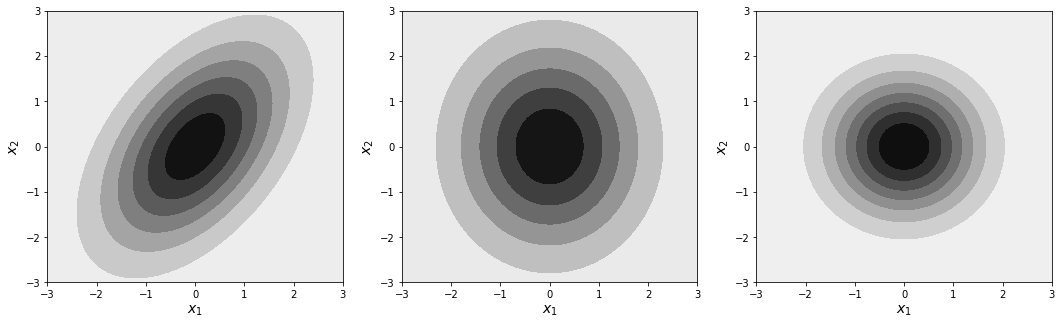

In [17]:
# Generate 100 points in the interval [-5, 5]
N = 100
X1, X2 = np.meshgrid(np.linspace(-5, 5, N), np.linspace(-5, 5, N))
X = np.array([np.ravel(X1), np.ravel(X2)])

plt.figure(figsize=(18, 5))

# General covariance matrix
generic_sigma = np.array(
    [[1.5, 0.92],
     [0.92, 2.2]]
)
N_distribution = MultivariateGaussian(np.zeros((2, 1)), generic_sigma)
p = np.diag(N_distribution.pdf(X)).reshape(X1.shape)

plt.subplot(1, 3, 1)
plt.contourf(X1, X2, p, cmap='binary')
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.axis([-3, 3, -3, 3])

# Diagonal covariance matrix
diagonal_sigma = np.array(
    [[1.5, 0],
     [0, 2.2]]
)
N_distribution = MultivariateGaussian(np.zeros((2, 1)), diagonal_sigma)
p = np.diag(N_distribution.pdf(X)).reshape(X1.shape)

plt.subplot(1, 3, 2)
plt.contourf(X1, X2, p, cmap='binary')
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.axis([-3, 3, -3, 3])

# Isotropic covariance matrix
isotropic_sigma = np.array(
    [[1.0, 0],
     [0, 1.0]]
)
N_distribution = MultivariateGaussian(np.zeros((2, 1)), isotropic_sigma)
p = np.diag(N_distribution.pdf(X)).reshape(X1.shape)

plt.subplot(1, 3, 3)
plt.contourf(X1, X2, p, cmap='binary')
plt.xlabel('$x_1$', fontsize=14); plt.ylabel('$x_2$', fontsize=14)
plt.axis([-3, 3, -3, 3])

plt.show()

### 2.3.4 Maximum likelihood for the Gaussian

Given a data set $\mathbf{X}=(\mathbf{x}_1,\dots,\mathbf{x}_N)^\text{T}$, in which the observations $\mathbf{x}_n$ are assumed to be drawn indepdendently from a multivariate Gaussian distribution, we can estimate the parameters of the distribution by maximum likelihood. The logarithm of the likelihood function is given by

$$
\begin{align*}
\ln p(\mathbf{X}|\boldsymbol\mu,\mathbf{\Sigma}) &= 
\ln \bigg( \prod_{n=1}^N \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu,\mathbf{\Sigma}) \bigg) \\
&= \ln \bigg( \prod_{n=1}^N \frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}} \exp\Big\{-\frac{1}{2}(\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu)\Big\} \bigg) \\
=& \sum_{n=1}^N \ln \bigg( \frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}} \exp\Big\{-\frac{1}{2}(\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu)\Big\} \bigg) \\
=& \sum_{n=1}^N \ln \bigg( \frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}} \bigg) + \sum_{n=1}^N \ln \exp\Big\{-\frac{1}{2}(\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu)\Big\} \\
=& N \ln \bigg( \frac{1}{(2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2}} \bigg) -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \\
=& - N \ln \big( (2\pi)^{D/2}|\mathbf{\Sigma}|^{1/2} \big) -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \\
=& - \frac{ND}{2} \ln(2\pi) - \frac{N}{2} \ln|\mathbf{\Sigma}| -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \\
\end{align*}
$$

Taking the derivative of the log-likelihood over $\boldsymbol\mu$ and set it equal to $0$, we obtain the solution for the maximum likelihood estimate of the mean, given by

$$
\begin{align*}
\frac{\partial}{\partial\boldsymbol\mu} \ln p(\mathbf{X}|\boldsymbol\mu,\mathbf{\Sigma}) = 0 &\Leftrightarrow
\frac{\partial}{\partial\boldsymbol\mu} \bigg( - \frac{ND}{2} \ln(2\pi) - \frac{N}{2} \ln|\mathbf{\Sigma}| -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 0 \\
&\Leftrightarrow \frac{\partial}{\partial\boldsymbol\mu} \bigg( -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 0 \\
&\Leftrightarrow -\frac{1}{2} \sum_{n=1}^N \mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) = 0 \\
&\Leftrightarrow \sum_{n=1}^N \mathbf{x}_n - N\boldsymbol\mu = 0 \\
&\Leftrightarrow \boldsymbol\mu_{ML} = \frac{1}{N} \sum_{n=1}^N \mathbf{x}_n
\end{align*}
$$

which is often called the *sample mean vector*. Calculating the derivative of the log-likelihood over $\mathbf{\Sigma}$ and set it equal to $0$ is given by

$$
\begin{align*}
\frac{\partial}{\partial\mathbf{\Sigma}} \ln p(\mathbf{X}|\boldsymbol\mu,\mathbf{\Sigma}) = 0 &\Leftrightarrow
\frac{\partial}{\partial\mathbf{\Sigma}} \bigg( - \frac{ND}{2} \ln(2\pi) - \frac{N}{2} \ln|\mathbf{\Sigma}| -\frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 0 \\
&\Leftrightarrow \frac{\partial}{\partial\mathbf{\Sigma}} \bigg(- \frac{N}{2} \ln|\mathbf{\Sigma}| \bigg)-\frac{\partial}{\partial\mathbf{\Sigma}} \bigg( \frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 0 \\
\end{align*}
$$

By using (C.28) the first term can be reduced to

$$
\frac{\partial}{\partial\mathbf{\Sigma}} \bigg( -\frac{N}{2} \ln|\mathbf{\Sigma}| \bigg) =
-\frac{N}{2} (\mathbf{\Sigma}^{-1})^\text{T} =
-\frac{N}{2} \mathbf{\Sigma}^{-1}
$$

where the last equality holds because $\mathbf{\Sigma}$ is symmetric. For the second term, we can derive that,

$$
\frac{\partial}{\partial\mathbf{\Sigma}} \bigg( \frac{1}{2} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)^\text{T}\mathbf{\Sigma}^{-1}(\mathbf{x}_n-\boldsymbol\mu) \bigg) = 
\frac{N}{2}\mathbf{\Sigma}^{-1}\mathbf{S}\mathbf{\Sigma}^{-1}
$$

where 

$$
\mathbf{S}=\frac{1}{N}=\sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu)(\mathbf{x}_n-\boldsymbol\mu)^\text{T}
$$

Thus, we obtain

$$
\begin{align*}
-\frac{N}{2} \mathbf{\Sigma}^{-1} + \frac{N}{2}\mathbf{\Sigma}^{-1}\mathbf{S}\mathbf{\Sigma}^{-1} &= 0
\Leftrightarrow\\
\frac{N}{2}\mathbf{\Sigma}^{-1}\mathbf{S}\mathbf{\Sigma}^{-1} &= \frac{N}{2} \mathbf{\Sigma}^{-1}
\Leftrightarrow\\
\mathbf{\Sigma} &= \mathbf{S}
\Leftrightarrow\\
\mathbf{\Sigma}_{ML} &= \frac{1}{N}=\sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu_{ML})(\mathbf{x}_n-\boldsymbol\mu_{ML})^\text{T}
\end{align*}
$$

However, if we evaluate the expectations of the maximum likelihood solutions under the true distribution, we obtain the following results

$$
\mathbb{E}[\boldsymbol\mu_{ML}] = \frac{1}{N}\mathbb{E}\bigg[ \sum_{n=1}^N \mathbf{x}_n \bigg] =
\frac{1}{N}\sum_{n=1}^N\mathbb{E}[\mathbf{x}_n] = \frac{1}{N} N\boldsymbol\mu = \boldsymbol\mu
$$

and

$$
\mathbb{E}[\mathbf{\Sigma}_{ML}] = \frac{N-1}{N}\mathbf{\Sigma}
$$

Thus, similar to the univariate Gaussian distribution, the expectation of the maximum likelihood estimate for the mean is equal to the true mean, while for the covariance has an expectation that is less than the true value, and hence it is biased. We can correct the bias by defining a different estimator given by

$$
\tilde{\mathbf{\Sigma}} = \frac{1}{N-1} \sum_{n=1}^N (\mathbf{x}_n-\boldsymbol\mu_{ML})(\mathbf{x}_n-\boldsymbol\mu_{ML})^\text{T}
$$

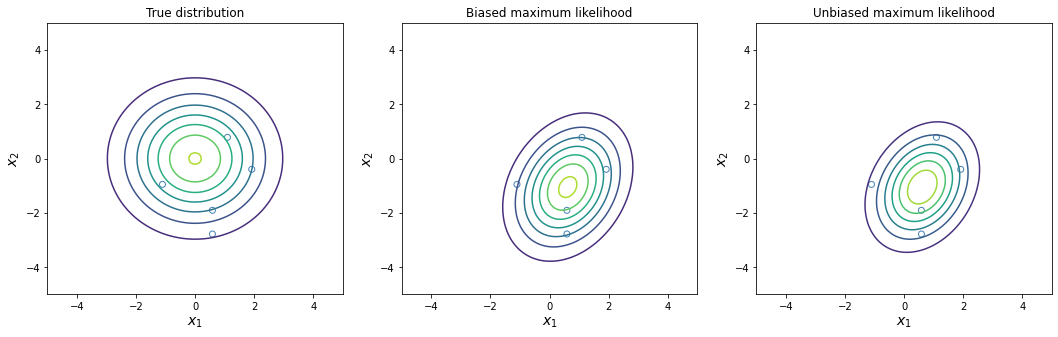

In [18]:
X = np.random.multivariate_normal(mean=np.array([0, 0]), cov=1.5 ** 2 * np.eye(2), size=5)

x, y = np.meshgrid(np.linspace(-5, 5, 100), np.linspace(-5, 5, 100))

plt.figure(figsize=(18, 5))

gaussian = MultivariateGaussian(mu=np.zeros((2, 1)), cov=1.5 ** 2 * np.eye(2))
p = np.diag(gaussian.pdf(np.array([x, y]).reshape(2, -1))).reshape(100, 100)

plt.subplot(1, 3, 1)
plt.contour(x, y, p)
plt.scatter(X[:, 0], X[:, 1], facecolor="none", edgecolor="steelblue")
plt.xlabel("$x_1$", fontsize=14); plt.ylabel("$x_2$", fontsize=14)
plt.title('True distribution')

gaussian = MultivariateGaussian(dim=2)
gaussian.ml(X, unbiased=False)
p = np.diag(gaussian.pdf(np.array([x, y]).reshape(2, -1))).reshape(100, 100)

plt.subplot(1, 3, 2)
plt.contour(x, y, p)
plt.scatter(X[:, 0], X[:, 1], facecolor="none", edgecolor="steelblue")
plt.xlabel("$x_1$", fontsize=14); plt.ylabel("$x_2$", fontsize=14)
plt.title('Biased maximum likelihood')

gaussian1 = MultivariateGaussian(dim=2)
gaussian1.ml(X, unbiased=True)
p1 = np.diag(gaussian1.pdf(np.array([x, y]).reshape(2, -1))).reshape(100, 100)

plt.subplot(1, 3, 3)
plt.contour(x, y, p1)
plt.scatter(X[:, 0], X[:, 1], facecolor="none", edgecolor="steelblue")
plt.xlabel("$x_1$", fontsize=14); plt.ylabel("$x_2$", fontsize=14)
plt.title('Unbiased maximum likelihood')

plt.show()

### 2.3.5 Sequential estimation

Sequential or online methods allow data points to be processed one at a time and then discarded. They are important when large data sets are involved so that batch processing of all data at once is infeasible. Consider for instance, the maximum likelihood solution for the multivariate Gaussian distribution. Lets denote  the solution based on $N$ observations as $\boldsymbol\mu_{ML}^{(N)}$. The, by dissecting the contribution from the final data point $\mathbf{x}_N$ we obtain

$$
\begin{align*}
\boldsymbol\mu_{ML}^{(N)} &= \frac{1}{N}\sum_{n=1}^N \mathbf{x}_n \\
&= \frac{1}{N}\mathbf{x}_Ν + \frac{1}{N}\sum_{n=1}^{N-1} \mathbf{x}_n \\
&= \frac{1}{N}\mathbf{x}_Ν + \frac{N-1}{N}\boldsymbol\mu_{ML}^{(N-1)} \\
&= \boldsymbol\mu_{ML}^{(N-1)} + \frac{1}{N}\big(\mathbf{x}_N - \boldsymbol\mu_{ML}^{(N-1)}\big) \\
\end{align*}
$$

Therefore, observing the data point $\mathbf{x}_N$ revises the estimate by moving the old estimate $\boldsymbol\mu_{ML}^{(N-1)}$ a small amount proportional to $1/N$ in the direction of the *error signal* ($\mathbf{x}_N - \boldsymbol\mu_{ML}^{(N-1)}$). Note that, as $N$ increases, the constribution of successive data points gets smaller.

Unfortunately, there is not always possible to derive a sequential algorithm by this route. Therefore, we seek a more general formulation of sequential learning, which leads us to the **Robbins-Monro** algorithm. Consider a pair of random variables $\theta$ and $z$ governed by a joint distribution $p(\theta,z)$. The conditional expectation of $z$ given $\theta$ is given by

$$
\mathbb{E}[z|\theta] = \int z p(z|\theta) dz
$$

The Robbins-Monro procedure defines a sequence of succesive estimates of the root $\theta^\star$ given by

$$
\theta^{(N)} = \theta^{(N-1)} - a_{N-1}z(\theta^{(N-1)})
$$

where $z(\theta^{(N-1)})$ is the observed value of $z$ when $\theta$ takes the value $\theta^{(N-1)}$.

In the case of the maximum likelihood solution we know that

$$
\frac{\partial}{\partial\theta}\bigg\{ -\frac{1}{N} \sum_{n=1}^N \ln p(x_n|\theta) \bigg\} = 0
\Leftrightarrow -\frac{1}{N} \sum_{n=1}^N \frac{\partial}{\partial\theta}\ln p(x_n|\theta) = 0
$$

Taking the limit $N \to \infty$ we have

$$
-\lim_{N \to \infty} \frac{1}{N} \sum_{n=1}^N \frac{\partial}{\partial\theta}\ln p(x_n|\theta)
= \mathbb{E} \bigg[ -\frac{\partial}{\partial\theta}\ln p(x_n|\theta) \bigg]
$$

and so finding the maximum likelihood solution corresponds to finding the root of the regression function. Thus, Robbins-Monro procedure takes the form

$$
\theta^{(N)} = \theta^{(N-1)} - a_{N-1}\frac{\partial}{\partial\theta^{(N-1)}}[-\ln p(x_n|\theta^{(N-1)})]
$$

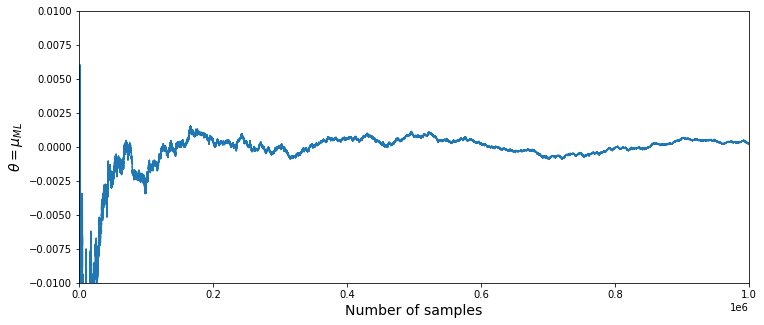

In [19]:
sample = np.random.randn(1000000)

sum_s = sample[0]
theta_n = sum_s / 1
history = [theta_n]
for N, s in enumerate(sample[1:], 2):
    theta_n = sum_s / N + 1 / N * (s - sum_s / N)
    sum_s += s
    history.append(theta_n)

plt.figure(figsize=(12, 5))
plt.plot(history)
plt.xlim(0, 1000000); plt.ylim(-0.01, 0.01)
plt.xlabel("Number of samples", fontsize=14); plt.ylabel("$\\theta=\mu_{ML}$", fontsize=14)
plt.show()

### 2.3.6 Bayesian inference for the Gaussian

Now we develop a Bayesian treatment by introducing prior distributions over the parameters for the mean and variance. Consider a single Gaussian random variable $x$, for which we are given a set of $N$ observations $\mathsf{x}=\{x_1,\dots,x_N\}$.

**1. Suppose that the variance $\sigma^2$ is known and we consider the task of inferring the mean $\mu$:**

The likelihood function is given by

$$
p(\mathsf{x}|\mu) = \prod_{n=1}^N p(x_n|\mu) = 
\prod_{n=1}^N \frac{1}{(2\pi\sigma^2)^{1/2}}\exp\Big\{-\frac{1}{2\sigma^2}(x_n-\mu)^2\Big\} =
\frac{1}{(2\pi\sigma^2)^{N/2}}\exp\Big\{-\frac{1}{2\sigma^2}\sum_{n=1}^N(x_n-\mu)^2\Big\}
$$

**NOTE:** The likelihood function is **not** a probability distribution over $\mu$ and is not normalized.

A Gaussian prior $p(\mu)$ is a conjugate for the likelihood function, because the corresponding posterior is then given by the product of exponentials of quadratic functions of $\mu$ that results in a Gaussian. Thererfore, the prior has the form

$$
p(\mu) = \mathcal{N}(\mu|\mu_0,\sigma_0^2)
$$

and the posterior distribution can be proved to be given by

$$
p(\mu|\mathsf{x}) = \mathcal{N}(\mu|\mu_N,\sigma_N^2)
$$

where

$$
\begin{align*}
\mu_N &= \frac{\sigma^2}{N\sigma_0^2+\sigma^2}\mu_0 + \frac{N\sigma_0^2}{N\sigma_0^2+\sigma^2}\mu_{ML}^2 \\
\sigma_N^2 &= \sigma_0^2 + \frac{1}{N}\sigma^2
\end{align*}
$$

Note that the mean of the posterior is a compromise between the prior mean $\mu_0$ and the maximum likelihood solution $\mu_{ML}$. If the number of observed data points $N=0$, then $\mu_N$ and $\sigma_N^2$ reduce to the prior mean $\mu_0$ and variance $\sigma_0^2$ as expected. For $N\to\infty$, the posterior mean is given by the maximum likelihood solution $\mu_{ML}$, while the variance goes to zero and the posterior distribution becomes infinitely peaked around the maximum likelihood solution.

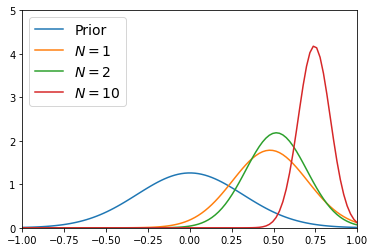

In [20]:
x = np.linspace(-1, 1, 100)

prior = Gaussian(0, 0.1)
plt.plot(x, prior.pdf(x), label="Prior")

N=1
sample = Gaussian(mu=0.8, var=0.1**2).draw(N)
mN = (N * 0.1 * np.mean(sample)) / (N * 0.1 + 0.1)
varN= 1 / ((1 / 0.1) + (N / 0.1))
plt.plot(x, Gaussian(mN, varN).pdf(x), label="$N=1$")

N=2
sample = Gaussian(mu=0.8, var=0.1**2).draw(N)
mN = (N*(0.1)*np.mean(sample)) / (N * 0.1 + 0.1)
varN= 1 / ((1 / 0.1) + (N / 0.1))
plt.plot(x, Gaussian(mN, varN).pdf(x), label="$N=2$")

N=10
sample = Gaussian(mu=0.8, var=0.1**2).draw(N)
mN = (N * 0.1 * np.mean(sample)) / (N * 0.1 + 0.1)
varN= 1 / ((1 / 0.1) + (N / 0.1))
plt.plot(x, Gaussian(mN, varN).pdf(x), label="$N=10$")

plt.xlim(-1, 1); plt.ylim(0, 5)
plt.legend(fontsize=14)
plt.show()

**2. Supporse that the mean $\mu$ is known and we wish to infer the variance $\sigma^2$:**

The likelihood function is given by

$$
p(\mathsf{x}|\lambda^{-1}) = \prod_{n=1}^N p(x_n|\lambda^{-1}) = 
\frac{\lambda^{N/2}}{\sqrt{2\pi\sigma^2}}\exp\Big\{-\frac{\lambda}{2}\sum_{n=1}^N (x - \mu)^2 \Big\}
$$

where we choose to use the precision $\lambda=1/\sigma^2$ for convenience.

The corresponding conjugate prior should therefore be proportional to the product of a power of $\lambda$ and the exponential of a linear function of $\lambda$, which corresponds to a *gamma* distribution

$$
\text{Gam}(\lambda|a,b) = \frac{1}{\Gamma(a)}b^a\lambda^{a-1}\exp(-b\lambda)
$$

In the case of variance, the conjugate prior is called the *inverse gamma* distribution. The mean of the gamma distribution is given by

$$
\begin{align*}
\mathbb{E}[\lambda] &= \int_0^{\infty} \lambda \frac{1}{\Gamma(a)}b^a\lambda^{a-1}\exp(-b\lambda) d\lambda \\
&= \frac{b^a}{\Gamma(a)} \int_0^{\infty} \lambda^a\exp(-b\lambda) d\lambda \\
&\overset{u=b\lambda}= \frac{b^a}{\Gamma(a)} \int_0^{\infty} \frac{u^a}{b^a}\exp(-u) \frac{1}{b}du \\
&= \frac{1}{b\Gamma(a)} \int_0^{\infty} u^a\exp(-u)du \\
&= \frac{1}{b\Gamma(a)} \int_0^{\infty} u^a\exp(-u)du \\
&= \frac{1}{b\Gamma(a)} \Gamma(a+1) = \frac{1}{b\Gamma(a)} a\Gamma(a) = \frac{a}{b} \\
\end{align*}
$$

where we have used the gamma function definition

$$
\Gamma(x) = \int_0^{\infty} u^{x-1}e^{-u}du
$$

The variance is given by

$$
\begin{align*}
\text{var}[\lambda] &= \mathbb{E}[\lambda^2] - \mathbb{E}[\lambda]^2 \\
&= \mathbb{E}[\lambda^2] - \frac{a^2}{b^2} \\
&= \int_0^{\infty} \lambda^2\text{Gam}(\lambda|a,b)d\lambda - \frac{a^2}{b^2} \\
&= \int_0^{\infty} \lambda^2 \frac{1}{\Gamma(a)}b^a\lambda^{a-1}\exp(-b\lambda) d\lambda - \frac{a^2}{b^2} \\
&= \frac{b^a}{\Gamma(a)} \int_0^{\infty} \lambda^{a+1}\exp(-b\lambda) d\lambda - \frac{a^2}{b^2} \\
&\overset{u=b\lambda}= 
\frac{b^a}{\Gamma(a)} \int_0^{\infty} \frac{u^{a+1}}{b^{a+1}}\exp(-u)\frac{1}{b}du - \frac{a^2}{b^2} \\
&= \frac{1}{b^2\Gamma(a)} \int_0^{\infty} u^{a+1}\exp(-u) du - \frac{a^2}{b^2} \\
&= \frac{1}{b^2\Gamma(a)} \Gamma(a+2) - \frac{a^2}{b^2} \\
&= \frac{1}{b^2\Gamma(a)} a(a+1)\Gamma(a) - \frac{a^2}{b^2} = \frac{a(a+1)}{b^2} - \frac{a^2}{b^2}
= \frac{a}{b^2}
\end{align*}
$$

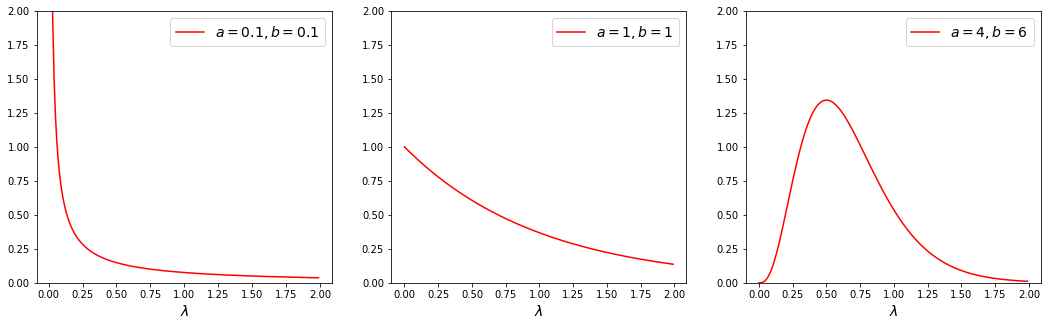

In [21]:
lambda_space = np.arange(0, 2, 0.01)

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(lambda_space, Gamma(a=0.1, b=0.1).pdf(lambda_space), color="red", label="$a=0.1, b=0.1$")
plt.ylim(0, 2)
plt.xlabel("$\lambda$", fontsize=14);
plt.legend(fontsize=14)

plt.subplot(1, 3, 2)
plt.plot(lambda_space, Gamma(a=1, b=1).pdf(lambda_space), color="red", label="$a=1, b=1$")
plt.ylim(0, 2)
plt.xlabel("$\lambda$", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 3, 3)
plt.plot(lambda_space, Gamma(a=4, b=6).pdf(lambda_space), color="red", label="$a=4, b=6$")
plt.ylim(0, 2)
plt.xlabel("$\lambda$", fontsize=14)
plt.legend(fontsize=14)

plt.show()

Considering a prior $\text{Gam}(\lambda|a_0,b_0)$ and multiplying by the likelihood function, we obtain an **unnormalized** posterior distribution of the form

$$
p(\lambda|\mathsf{x}) \propto \lambda^{a_0-1}\lambda^{N/2}\exp\{-b_0\lambda-\frac{\lambda}{2}\sum_{n=1}^N(x_n-\mu)^2 \}
$$

which is a gamma distribution $\text{Gam}(\lambda|a_N,b_N)$

$$
\begin{align*}
a_N &= a_0 + \frac{N}{2} \\
b_N &= b_0 + \frac{1}{2}\sum_{n=1}^N (x_n-\mu)^2 = b_0 + \frac{N}{2}\sigma_{ML}^2
\end{align*}
$$

Thus, the effect of observing $N$ data points is to increase the value of the coefficient $a$ by $\frac{N}{2}$ and the value of coefficient $b$ by $\frac{N}{2}\sigma_{ML}^2$.

**3. Suppose that both the mean $\mu$ and the variance $\sigma^2$ are unknown:**

**TODO**

### 2.3.7 Student's t-distribution

Consider a univariate Gaussian distribution $\mathcal{N}(x|\mu,\tau^{-1})$ and a gamma prior $\text{Gam}(\tau|a,b)$. If we integrate out the precision $\tau$, we obtain the marginal distribution of $x$ in the form

$$
p(x|\mu,a,b) = \int_0^{\infty} \mathcal{N}(x|\mu,\tau^{-1})\text{Gam}(\tau|a,b)d\tau =
\frac{b^a}{\Gamma(a)} \bigg(\frac{1}{2\pi}\bigg)^{1/2} \bigg[b + \frac{(x-\mu)^2}{2}\bigg]^{-a-1/2}\Gamma(a+1/2)
$$

where we have made the change of variable $z=\tau[b+(x-\mu)^2/2]$. By defining new parameters given by $\nu=2a$ and $\lambda=a/b$, the distribution $p(x|\mu,a,b)$ takes the form

$$
\text{St}(x|\mu,\lambda,\nu) =
\frac{\Gamma(\nu/2 + 1/2)}{\Gamma(\nu/2)} \bigg(\frac{\lambda}{\pi\nu}\bigg)^{1/2}
\bigg[1 + \frac{\lambda(x-\mu)^2}{\nu}\bigg]^{-\nu/2-1/2}
$$

which is known as *Student's t-distribution*. The parameter $\lambda$ is called the $precision$ of the t-distribution, **even though it is not equal to inverse of the variance**, while the parameter $\nu$ is called the degrees of freedom.

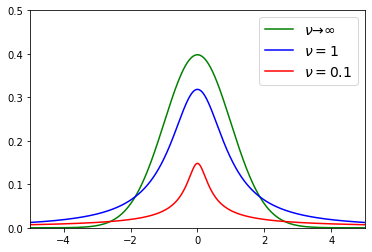

In [22]:
x_space = np.arange(-5, 5, 0.01)

plt.plot(x_space, StudentT(nu=100).pdf(x_space), color="green", label="$\\nu\\to\\infty$")
plt.plot(x_space, StudentT(nu=1).pdf(x_space), color="blue", label="$\\nu=1$")
plt.plot(x_space, StudentT(nu=0.1).pdf(x_space), color="red", label="$\\nu=0.1$")
plt.xlim(-5, 5); plt.ylim(0, 0.5)
plt.legend(fontsize=14)

plt.show()

For $\nu=1$ the t-distribution reduces to the *Cauchy* distribution, while for $\nu\to\infty$ the t-distribution becomes a Gaussian.

Note that the Student's t-distribution is obtained by adding up an infinite number of Gaussian distributions having the same mean, but different precisions. Thus, the t-distribution can be interpreted as a *mixture* of Gaussians. The result of this mixture is that the distribution has longer *tails*, which gives the t-distribution an important property called *robustness*. Essentially, is much less sensitive, than the Gaussian, to the presence of few data points which are *outliers*.

### 2.3.9 Mixtures of Gaussians

Although the Gaussian distribution has important analytical properties, it also has significant limitations regarding to modelling real data sets. Consider for instance the *Old Faithful* dataset comprise $272$ measurements of the eruption of the Old Faithful geyser at Yellowstone National Park in the USA.

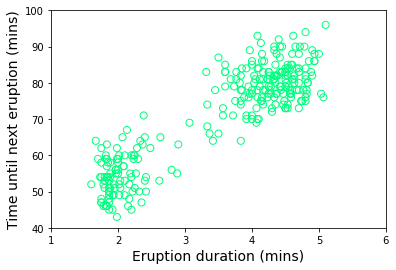

In [23]:
old_faithful = load_old_faithful()
plt.scatter(old_faithful[:,:1], old_faithful[:,1:2], color='springgreen', facecolors='none', s=50)
plt.xlim(1, 6); plt.ylim(40, 100)
plt.xlabel('Eruption duration (mins)', fontsize=14); plt.ylabel('Time until next eruption (mins)', fontsize=14)
plt.show()

Each measurement comprises the duration of the eruption in minutes ($x$-axis) and the time in minutes to the next eruption ($y$-axis). Note that the data forms two dominant modes. Therefore, a simple Gaussian distribution **should be unable to capture this structure**.

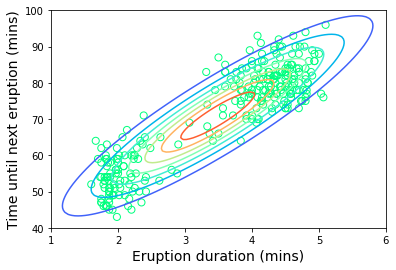

In [24]:
x, y = np.meshgrid(np.linspace(1, 6, 100), np.linspace(40, 100, 100))

# Perform maximum likelihood over the dataset
model = MultivariateGaussian(dim=2)
model.ml(old_faithful)
p = np.diag(model.pdf(np.array([x, y]).reshape(2, -1))).reshape(100, 100)

plt.scatter(old_faithful[:,:1], old_faithful[:,1:2], color='springgreen', facecolors='none', s=50)
plt.contour(x, y, p, cmap="rainbow")
plt.xlim(1, 6); plt.ylim(40, 100)
plt.xlabel('Eruption duration (mins)', fontsize=14); plt.ylabel('Time until next eruption (mins)', fontsize=14)
plt.show()

On the other hand, a linear combination (superposition) of two Gaussians should give a better characterization of the data since it should be able to place one Gaussian on each mode of the data. Such superpositions, formed by taking linear combinations of more basic distributions such as Gaussians, can be formulated as probabilistic models known as *mixture distributions*. We therefore define a superposition of $K$ Gaussian densities of the form

$$
p(\mathbf{x}) = \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)
$$

which is called a *mixture of Gaussians*. Each Gaussian density is called a *component of the mixture* and the parameters $\pi_k$ are called the *mixing coefficients*. By using a sufficient number of Gaussians, and by optimizing their means and covariances, as well as the coefficients $\pi_k$ in the linear combination, almost any continuous density can be approximated to arbitrary accuracy.

By integrating both sides of (2.188) over $\mathbf{x}$, and noting that both $p(\mathbf{x})$ and the individual Gaussian components are normalized, we obtain

$$
\begin{align*}
& \int p(\mathbf{x})d\mathbf{x} = 
\int \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)d\mathbf{x} 
\Leftrightarrow \\
& \sum_{k=1}^K \pi_k \int \mathcal{N}(\mathbf{x}|\boldsymbol\mu_k,\mathbf{\Sigma}_k)d\mathbf{x} = 1
\Leftrightarrow \\
& \sum_{k=1}^K \pi_k = 1
\end{align*}
$$

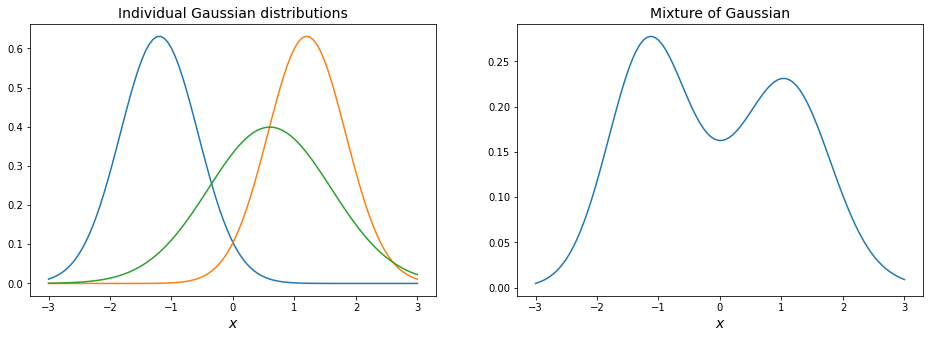

In [25]:
x_space = np.linspace(-3, 3, 100)

# Mixture component's parameters and coefficients
mu1, mu2, mu3 = -1.2, 1.2, 0.6
var1, var2, var3 = 0.4, 0.4, 1
pi1, pi2, pi3 = 0.4, 0.2, 0.3

component1 = Gaussian(mu=mu1, var=var1).pdf(x_space)
component2 = Gaussian(mu=mu2, var=var2).pdf(x_space)
component3 = Gaussian(mu=mu3, var=var3).pdf(x_space)

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(x_space, component1, label="component 1")
plt.plot(x_space, component2, label="component 1")
plt.plot(x_space, component3, label="component 1")
plt.xlabel("$x$", fontsize=14)
plt.title("Individual Gaussian distributions", fontsize=14)

plt.subplot(1, 2, 2)
plt.plot(x_space, pi1 * component1 + pi2 * component2 + pi3 * component3)
plt.xlabel("$x$", fontsize=14)
plt.title("Mixture of Gaussian", fontsize=14)

plt.show()

Given a dataset $\mathbf{X} = \{ \mathbf{x}_1,\dots,\mathbf{x}_N \}$, one way of finding the values of the parameters is to use maximum likelihood

$$
\ln p(\mathbf{X}|\boldsymbol\pi,\boldsymbol\mu,\mathbf{\Sigma}) = 
\ln \bigg(\prod_{n=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(\mathbf{x}_n|\boldsymbol\mu_k,\mathbf{\Sigma}_k)\bigg)
$$

Due to the presence of the summation over $k$ inside the logarithm, the derivation is much more complex than the case of a single Gaussian. As a result, the maximum likelihood solution for the parameters no longer has a closed-form analytical solution. One approach to maximizing the likelihood function is to use iterative numerical optimization techniques or employ a powerful framework called *Expectation-Maximization*.

## 2.5 Nonparametric Methods

The use of probability distributions of specific functional forms governed by a number of parameters whose values are to be determined from the data are called **parametric** approaches to density modelling. The main limitation of such approches is that the assumed density might be a poor model of the true underlying distribution that generated the data in the first place. This leads to poor predictive performance, such as in the case of the *Old faithful* dataset and the simple unimodal Gaussian distribution.

Now we consider some **nonparametric** approaches to density estimation that make fewer assumptions about the form of the distribution. We focus mainly on simple frequentist methods, however, there are also nonparametric Bayesian methods.

For presentation purposes, consider a single continuous variable $x$ that follows a mixture of two Gaussian distributions.

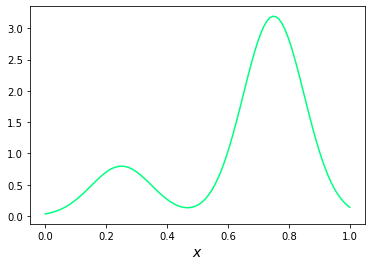

In [26]:
means = [0.25, 0.75]
variances = [.01, .01]
proportions = [.2, .8]

component1 = Gaussian(mu=means[0], var=variances[0])
component2 = Gaussian(mu=means[1], var=variances[1])

x_space = np.linspace(0, 1, 100)
y_space = proportions[0] * component1.pdf(x_space) + proportions[1] * component2.pdf(x_space)

plt.plot(x_space, y_space, color="springgreen")
plt.xlabel("$x$", fontsize=14)
plt.show()

First, lets discuss the histogram methods for density estimation. Standard histograms simply partition $x$ into distinct bins of width $\Delta_i$ and then count the number $n_i$ of observations of $x$ falling in bin $i$. In order to turn the counts into a normalized probability density, we divide by the total number $N$ of observations and by the width $\Delta_i$ of the bins to obtain probability values for each bin given by

$$
p_i = \frac{n_i}{N\Delta_i}
$$

Given a sample dataset of $N=50$ points, we plot three histogram density estimates corresponding to three choices for the bin width $\Delta$. For very small $\Delta$, the resulted density model is very spiky, while for very large $\Delta$ the result is too smooth and fails to capture the bimodal property of the curve. The best results are obtained by the intermediate value.

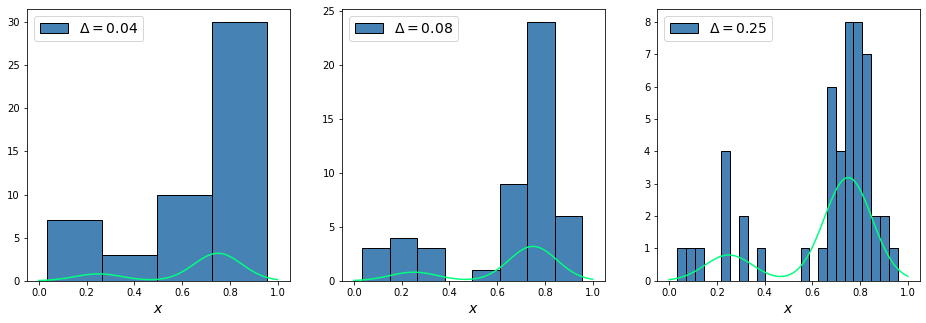

In [27]:
# Sample N points from the mixture
N = 50
N1 = int(N * proportions[0])
N2 = N - N1
sampled_points = component1.draw(N1)
sampled_points = np.append(sampled_points, component2.draw(N2))

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(x_space, y_space, color="springgreen")
plt.hist(sampled_points, bins=4, edgecolor='black', color="steelblue", label="$\\Delta=0.04$")
plt.xlabel("$x$", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 3, 2)
plt.plot(x_space, y_space, color="springgreen")
plt.hist(sampled_points, bins=8, edgecolor='black', color="steelblue", label="$\\Delta=0.08$")
plt.xlabel("$x$", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 3, 3)
plt.plot(x_space, y_space, color="springgreen")
plt.hist(sampled_points, bins=25, edgecolor='black', color="steelblue", label="$\\Delta=0.25$")
plt.xlabel("$x$", fontsize=14)
plt.legend(fontsize=14)

plt.show()

The histogram method has the desired property that, once the histogram has been computed, the data itself can be discarded. Moreover, the approach is easily applied to data points are arriving sequentially. However, a major limitation is its scaling on high dimensional data. If we divide each variable in a $D$-dimensional space into $M$ bins, then the total number of bins is $M^D$. Therefore, in a space of high dimensionality, the quantity of data needed to provide meaningful estimates of local probability density would be prohibitive.

The histogram approach to density estimation does, however, teach us two important lessons. 

1. In order to estimate the probability density at a particular location, we should consider the data points that lie within some local neighbourhood of that location. For histograms, the neighbourhood property was defined by the bins.


2. The value of the smoothing parameter should be neither too large nor too small in order to obtain good results.

### 2.5.1 Kernel density estimators

Now, suppose that observations are being drawn from an unknown probability density $p(\mathbf{x})$ in a $D$-dimensional Euclidean space. From our earlier insights about locality, let us consider a small region $\mathcal{R}$ containing $\mathbf{x}$. Then, the probability mass of this region is given by

$$
P_{\mathcal{R}} = \int_{\mathcal{R}} p(\mathbf{x})d\mathbf{x}
$$

Then, given a data set comprising $N$ observations drawn from $p(\mathbf{x})$, each data point has a probability $P_{\mathcal{R}}$ of falling into the region $\mathcal{R}$. Thus, in general, the total number $K$ of points out of $N$, that lie inside $\mathcal{R}$ are distributed according to a binomial distribution

$$
\text{Bin}(K|N,P_{\mathcal{R}}) = \frac{N!}{K!(N-K)!} P_{\mathcal{R}}^K(1-P_{\mathcal{R}})^{1-K}
$$

We can prove that the mean fraction of points falling inside the region $\mathcal{R}$ is $\mathbb{E}[K/N]=\frac{1}{N}NP_{\mathcal{R}}=P_{\mathcal{R}}$, and the variance around the mean $\text{var}[K/N]=P_{\mathcal{R}}(1-P_{\mathcal{R}})/N$. Therefore, assuming a large $N$, variance is going to shrink and the distribution is going to be sharply peaked around the mean, leading to a $P_{\mathcal{R}}$ proportion of the $N$ points ($K$) to be located inside $\mathcal{R}$

$$
K \approx NP_{\mathcal{R}}
$$

Furthermore, assuming that the region $\mathcal{R}$ is sufficiently small that the probability density $p(\mathbf{x})$ is roughly constant over the region, then we have

$$
P_{\mathcal{R}} \approx p(\mathbf{x})V
$$

where $V$ is the volume of $\mathcal{R}$. Combining these two assumptions, we obtain a density estimate in the form

$$
p(\mathbf{x}) = \frac{K}{NV}
$$

Note that the validity of the density depends on two **contradictory assumptions**, namely that the region $\mathcal{R}$ is sufficiently small that the density is approximately constant over the region and yet sufficiently large (in relation to the value of that density) that the number $K$ of points falling inside the region is sufficient for the binomial distribution to be sharply peaked.

We can exploit the resulted density in two different ways:

1. Assume a $K$ and determine the value of $V$ from the data, giving rise to the $k$-nearest neighbour technique. 

2. Assume a $V$ and determine $K$ from the data, giving rise to the kernel approach

It can be proved that both the $k$-nearest neighbour density estimator and the kernel density estimator converge to the true probability density in the limit $N\to\infty$ provided $V$ shrinks suitably with $N$, and $K$ grows with $N$.

Consider the region $\mathcal{R}$ to be a small hypercube centred on the point $\mathbf{x}$ at which we wish to determine the probability density. In order to count the number $K$ of points falling inside $\mathcal{R}$, it is convenient to define the function

$$
k(\mathbf{u}) = 
\begin{cases}
 1, & \quad |u_i| \leq \frac{1}{2}, \quad \forall i \in \{1,\dots,D\} \\
 0, & \quad \text{otherwise}
\end{cases}
$$

which represents a unit cube centred on the origin.

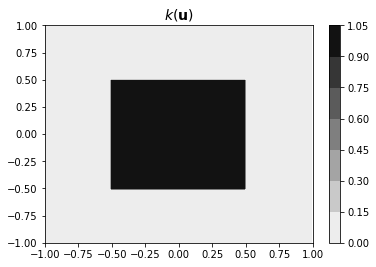

In [28]:
def k(u): return np.all(np.abs(u) <= 0.5)

U1, U2 = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))
plt.contourf(U1, U2, np.apply_along_axis(k, 0, np.array([U1, U2])), cmap="binary")
plt.title("$k(\mathbf{u})$", fontsize=14)
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.colorbar(); plt.show()

The function $k(\mathbf{u})$ is an example of a *kernel function*, also called a **Parzen window**. The quantity $k(\frac{\mathbf{x} - \mathbf{x}_n}{h})$ is $1$ if the data point $\mathbf{x}_n$ lies inside a cube of side $h$ centred on $\mathbf{x}$, and zero otherwise. The total number of data points lying inside this cube is therefore given by

$$
K = \sum_{n=1}^N k\bigg(\frac{\mathbf{x} - \mathbf{x}_n}{h}\bigg)
$$

By substituting the expression for $K$ into the formula of $p(\mathbf{x})$ derived above, we obtain the estimated density at $\mathbf{x}$ using a Parzen window

$$
p(\mathbf{x}) = \frac{1}{N} \sum_{n=1}^N \frac{1}{h^D} k\bigg(\frac{\mathbf{x}-\mathbf{x}_n}{h}\bigg)
$$

where $h^D = V$ for the volume of a hypercube of side $h$ in $D$ dimensions.

We can also interpret the above equation, not as a single cube centred on $\mathbf{x}$ but instead as the sum over $N$ cubes centred on the $N$ data points $\mathbf{x}_n$.

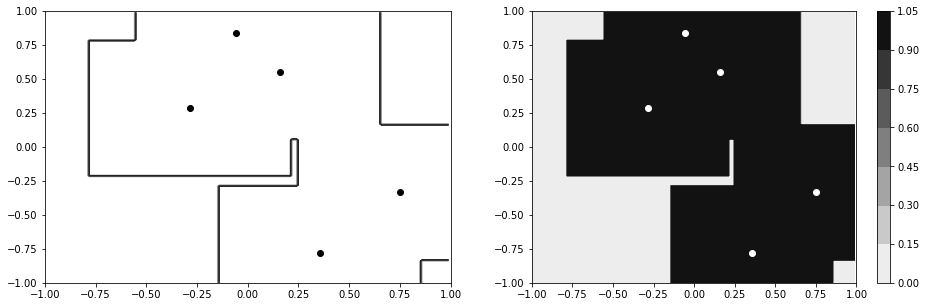

In [29]:
N = 5
h = 1
data = np.random.uniform(-1, 1, size=(N, 2))
U1, U2 = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))

K = np.zeros(U1.shape)
for x in data:
    k = lambda u: np.all(np.abs(x - u) <= h / 2)
    K += np.apply_along_axis(k, 0, np.array([U1, U2]))

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.contour(U1, U2, K > 0, cmap="binary")
plt.scatter(data[:,0], data[:,1], color="black")
plt.xlim(-1, 1); plt.ylim(-1, 1)

plt.subplot(1, 2, 2)
c = plt.contourf(U1, U2, K > 0, cmap="binary")
plt.scatter(data[:,0], data[:,1], color="w")
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.colorbar(c); plt.show()

The kernel density estimator suffers from one of the same problems that the histogram method suffered from, namely the presence of artificial discontinuities, in this case at the boundaries of the cubes. We can obtain a smoother density model if we choose a smoother kernel function, and a common choice is the Gaussian, that gives rise to the following kernel density model

$$
p(\mathbf{x}) = \frac{1}{N} \sum_{n=1}^N \frac{1}{(2\pi h^2)^{1/2}} 
\exp\bigg\{ -\frac{\|\mathbf{x} - \mathbf{x}_n\|^2}{2h^2} \bigg\}
$$

where $h$ represents the standard deviation of the Gaussian components. Thus, the density model is obtained by placing a Gaussian over each data point, adding up the contributions over the whole data set, and then dividing by $N$ so that the density is correctly normalized.

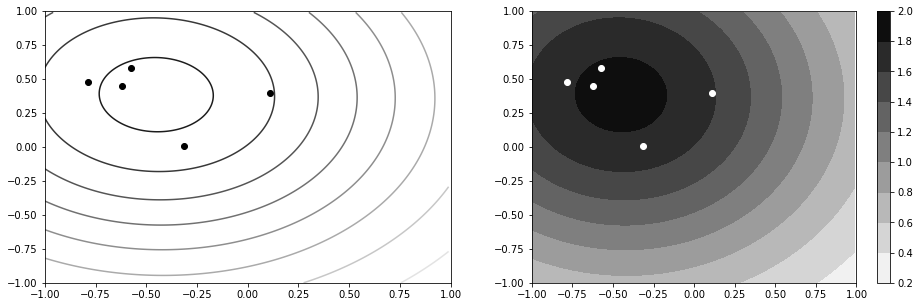

In [30]:
N = 5
h = 1
data = np.random.uniform(-1, 1, size=(N, 2))
U1, U2 = np.meshgrid(np.arange(-1, 1, 0.01), np.arange(-1, 1, 0.01))

K = np.zeros(U1.shape)
for x in data:
    k = lambda u: np.exp(-np.linalg.norm(x - u)**2 / (2*h**2)) / np.sqrt(2*np.pi*h**2)
    K += np.apply_along_axis(k, 0, np.array([U1, U2]))

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.contour(U1, U2, K, cmap="binary")
plt.scatter(data[:,0], data[:,1], color="black")
plt.xlim(-1, 1); plt.ylim(-1, 1)

plt.subplot(1, 2, 2)
c = plt.contourf(U1, U2, K, cmap="binary")
plt.scatter(data[:,0], data[:,1], color="w")
plt.xlim(-1, 1); plt.ylim(-1, 1)
plt.colorbar(c); plt.show()

Applying the Gaussian kernel to the data set used earlier to demonstrate the histogram technique, we see that, as expected, the parameter $h$ plays the role of a smoothing parameter, and there is a trade-off between sensitivity to noise at small h and over-smoothing at large h. Again, the optimization of h is a problem in model complexity, analogous to the choice of bin width in histogram density estimation, or the degree of the polynomial used in curve fitting.

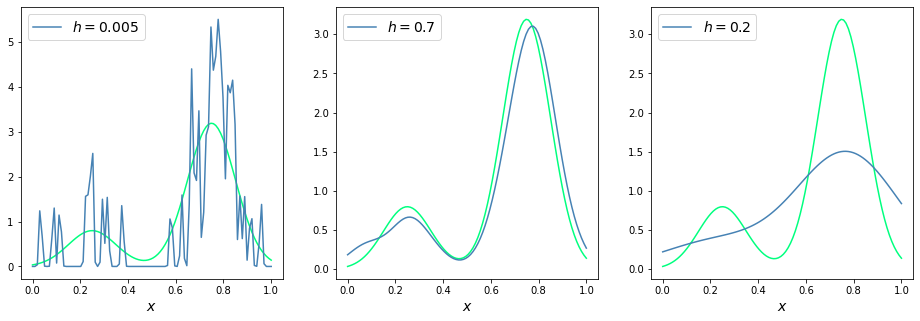

In [31]:
def gaussian_kernel_density(h, data, x):
    K = 0
    for xn in data:
        k = lambda x: np.exp(-np.linalg.norm(x - xn,)**2 / (2*h**2)) / np.sqrt(2*np.pi*h**2)
        K += k(x)
    return K / len(data)

def kdeg(x, X, h):
    """
    KDE under a gaussian kernel
    """
    N, D = X.shape
    nden, _ = x.shape # number of density points
    Xhat = X.reshape(D, 1, N)
    xhat = x.reshape(D, nden, 1)
    
    px = np.exp(-np.linalg.norm(xhat - Xhat, axis=0) ** 2 / (2*h**2)).sum(axis=1) / (N*np.sqrt(2*np.pi*h**2))
    return px

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(x_space, y_space, color="springgreen")
plt.plot(x_space, kdeg(x_space.reshape(-1, 1), sampled_points.reshape(-1, 1), 0.005),
         color="steelblue", label="$h=0.005$")
plt.xlabel("$x$", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 3, 2)
plt.plot(x_space, y_space, color="springgreen")
plt.plot(x_space, [gaussian_kernel_density(0.07, sampled_points, x) for x in x_space],
        color="steelblue", label="$h=0.7$")
plt.xlabel("$x$", fontsize=14)
plt.legend(fontsize=14)

plt.subplot(1, 3, 3)
plt.plot(x_space, y_space, color="springgreen")
plt.plot(x_space, [gaussian_kernel_density(0.2, sampled_points, x) for x in x_space],
         color="steelblue", label="$h=0.2$")
plt.xlabel("$x$", fontsize=14)
plt.legend(fontsize=14)

plt.show()

The class of density models given by the Parzen estimators have the advantage that there is no computation involved during the *training* phase. They simply store the training set. However, this is also their great weakness, since the cost of evaluating the density grows linearly with the size of the data.

### 2.5.2 Nearest-neighbour methods

This issue is addressed by nearest-neighbour methods for density estimation.

We therefore return to our general result (2.246) for local density estimation, and assume a value for $K$ and use the data to find an appropriate value for $V$. To that end, we consider a small sphere centred on the point $\mathbf{x}$ at which we wish to estimate the ensity $p(\mathbf{x})$. Then, we allow the radius of the sphere to grow until it contains precisely $K$ data points. The estimate of the density is then given by 

$$
p(\mathbf{x}) = \frac{K}{V_\text{shpere}N}
$$

where $V_\text{shpere}$ is volume of the resulting sphere. This technique is known as K nearest neighbours.

The n-dimensional volume of a Euclidean ball of radius R in n-dimensional Euclidean space is

$$
V_\text{shpere} = \frac{\pi^{D/2}r^D}{\Gamma(\frac{D}{2} + 1)}
$$

and is illustrated in Figure 2.26, for various choices of the parameter K, using the
same data set as used in Figure 2.24 and Figure 2.25. We see that the value of K
now governs the degree of smoothing and that again there is an optimum choice for
K that is neither too large nor too small. Note that the model produced by K nearest
neighbours is not a true density model because the integral over all space diverges.

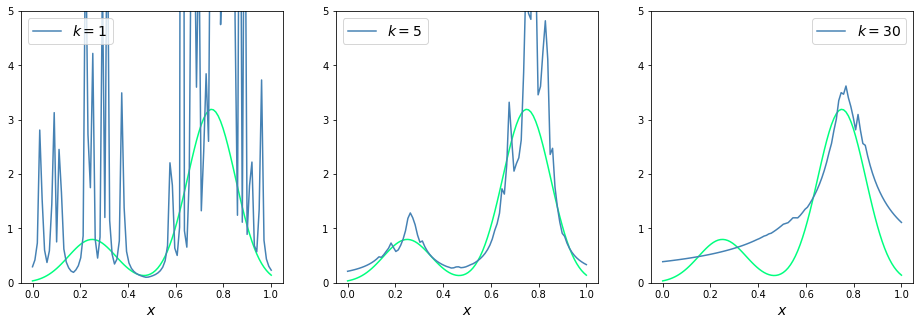

In [32]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(x_space, y_space, color="springgreen")
model = NearestNeighborsDensity(k=1)
model.fit(sampled_points) 
plt.plot(x_space, model.predict(x_space), color="steelblue", label="$k=1$")
plt.xlabel("$x$", fontsize=14); plt.ylim(0, 5)
plt.legend(fontsize=14)

plt.subplot(1, 3, 2)
plt.plot(x_space, y_space, color="springgreen")
model = NearestNeighborsDensity(k=5)
model.fit(sampled_points)
plt.plot(x_space, model.predict(x_space), color="steelblue", label="$k=5$")
plt.xlabel("$x$", fontsize=14); plt.ylim(0, 5)
plt.legend(fontsize=14)

plt.subplot(1, 3, 3)
plt.plot(x_space, y_space, color="springgreen")
model = NearestNeighborsDensity(k=30)
model.fit(sampled_points)
plt.plot(x_space, model.predict(x_space), color="steelblue", label="$k=30$")
plt.xlabel("$x$", fontsize=14); plt.ylim(0, 5)
plt.legend(fontsize=14)

plt.show()

The $K$-nearest-neighbour technique for density estimation can also be used for classification. To do so, we apply the $K$-nearest-neighbour density estimation technique to each class separately and then use the Bayes' theorem. Consider a data set comprising $N_k$ points in class $\mathcal{C}_k$ and $N$ points in total, so that $\sum_k N_k = N$. A sphere of volume $V$ containing $K_k$ points from class $\mathcal{C}_k$ defines the density of each class, given by

$$
p(\mathbf{x}|\mathcal{C}_k) = \frac{K_k}{N_kV}
$$

while, the unconditional density is given by

$$
p(\mathbf{x}) = \frac{K}{NV}
$$

and the class prior is given by

$$
p(\mathcal{C}_k) = \frac{N_k}{N}
$$

Using Bayes’ theorem, we obtain the posterior probability of class membership

$$
p(\mathcal{C}_k|\mathbf{x}) = \frac{p(\mathbf{x}|\mathcal{C}_k)p(\mathcal{C}_k)}{p(\mathbf{x})} =
\frac{K_k}{K}
$$

Thus, to classify a new point, we identify the $K$-nearest points from the training data set and then assign the new point to the class having the largest number of representatives amongst this set. Ties can be broken at random. The particular case of $K=1$ is called the *nearest-neighbour rule*, because a test point is simply assigned to the same class as the nearest point from the training set.

An interesting property of the nearest-neighbour rule classifier is that, in the limit $N\to\infty$, the error rate is never more than double the minimum achievable error rate of an optimal classifier, i.e., one that uses the true class distributions.

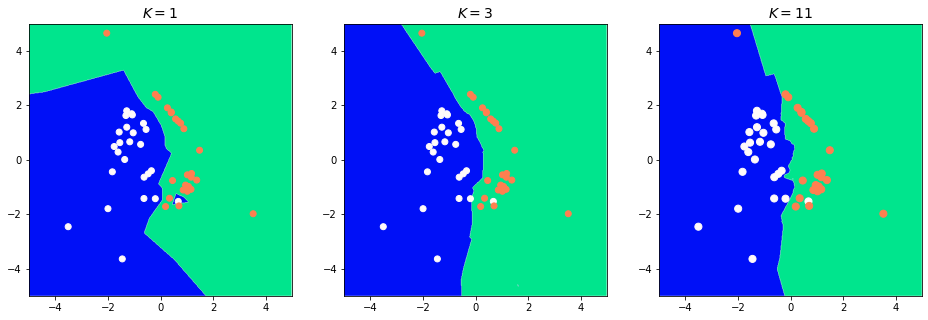

In [33]:
N = 50
D = 2

x, t = make_classification(n_features=D, 
                           n_informative=D,
                           n_redundant=0,
                           n_classes=2,
                           n_samples=N)

x_space = np.arange(-5, 5, 0.02)
x1, x2 = np.meshgrid(x_space, x_space)
x_hat = np.vstack((x1.ravel(), x2.ravel())).T

class_colors = ['coral' if t[i] == 1 else 'snow' for i in range(t.shape[0])]

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
model = KNearestNeighborsClassifier(k=1)
model.fit(x, t)
Z = model.predict(x_hat).reshape(-1, 1)
plt.contourf(x_space, x_space, Z[:,0].reshape(x1.shape), 
             cmap ='winter',levels=np.arange(-0.1, 1.1, 0.05), antialiased=True)
plt.scatter(x[:,0], x[:,1], color=class_colors)
plt.title("$K=1$", fontsize=14)

plt.subplot(1, 3, 2)
model = KNearestNeighborsClassifier(k=3)
model.fit(x, t)
Z = model.predict(x_hat).reshape(-1, 1)
plt.contourf(x_space, x_space, Z[:,0].reshape(x1.shape), 
             cmap ='winter',levels=np.arange(-0.1, 1.1, 0.05), antialiased=True)
plt.scatter(x[:,0], x[:,1], color=class_colors)
plt.title("$K=3$", fontsize=14)

plt.subplot(1, 3, 3)
model = KNearestNeighborsClassifier(k=11)
model.fit(x, t)
Z = model.predict(x_hat).reshape(-1, 1)
plt.contourf(x_space, x_space, Z[:,0].reshape(x1.shape), 
             cmap ='winter',levels=np.arange(-0.1, 1.1, 0.05), antialiased=True)
plt.scatter(x[:,0], x[:,1], color=class_colors, s=50)
plt.title("$K=11$", fontsize=14)

plt.show()

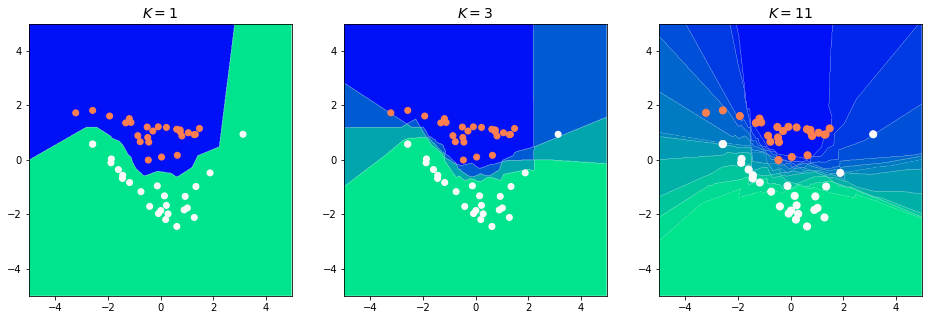

In [34]:
N = 50
D = 2

x, t = make_classification(n_features=D, 
                           n_informative=D,
                           n_redundant=0,
                           n_classes=2,
                           n_samples=N)

x_space = np.arange(-5, 5, 0.02)
x1, x2 = np.meshgrid(x_space, x_space)
x_hat = np.vstack((x1.ravel(), x2.ravel())).T

class_colors = ['coral' if t[i] == 1 else 'snow' for i in range(t.shape[0])]

plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
model = KNearestNeighborsClassifier(k=1)
model.fit(x, t)
Z = model.probability(x_hat)
plt.contourf(x_space, x_space, Z[:,0].reshape(x1.shape), 
             cmap ='winter',levels=np.arange(-0.1, 1.1, 0.05), antialiased=True)
plt.scatter(x[:,0], x[:,1], color=class_colors)
plt.title("$K=1$", fontsize=14)

plt.subplot(1, 3, 2)
model = KNearestNeighborsClassifier(k=3)
model.fit(x, t)
Z = model.probability(x_hat)
plt.contourf(x_space, x_space, Z[:,0].reshape(x1.shape), 
             cmap ='winter',levels=np.arange(-0.1, 1.1, 0.05), antialiased=True)
plt.scatter(x[:,0], x[:,1], color=class_colors)
plt.title("$K=3$", fontsize=14)

plt.subplot(1, 3, 3)
model = KNearestNeighborsClassifier(k=11)
model.fit(x, t)
Z = model.probability(x_hat)
plt.contourf(x_space, x_space, Z[:,0].reshape(x1.shape), 
             cmap ='winter',levels=np.arange(-0.1, 1.1, 0.05), antialiased=True)
plt.scatter(x[:,0], x[:,1], color=class_colors, s=50)
plt.title("$K=11$", fontsize=14)

plt.show()